# NextPNR Himbaechel Parameter Sweep

This notebook runs the nextpnr-himbaechel tool with different values of connectivity factor and congestion aware factor ranging from 0.1 to 2.0. It automates the parameter sweep to analyze the impact of these factors on placement and routing performance.

The notebook is based on the Fish shell script that runs FABulous FPGA tools and nextpnr-himbaechel for place and route optimization.

## Enhanced Failure Detection Features

This notebook now includes enhanced failure detection capabilities:

### 🔍 **Failure Type Classification**
- **Placement Failure**: Detected when "Final Placement" line is missing from logs
- **Routing Failure**: Detected when "ERROR: Max iteration count reached" appears in logs  
- **Timeout/Exception**: Handles process timeouts and unexpected errors

### 📊 **Additional Statistics**
- **Arc Queue Size**: Extracts and records arc_queue size from routing logs as a performance metric
- **Placement Success Rate**: Tracks placement success independently of overall success
- **Routing Success Rate**: Tracks routing success (given placement succeeded)

### 📈 **Enhanced Analysis**
- Failure type breakdown by parameter combinations
- Arc queue size comparison between successful and failed runs
- Detailed per-source file statistics including placement/routing success rates

This enhanced analysis helps identify whether optimization efforts should focus on placement parameters, routing parameters, or both.

## 1. Import Required Libraries

Import necessary Python modules for running shell commands, managing files, and handling results.

In [1]:
# Enable auto reload for imports
%load_ext autoreload
%autoreload 2

import subprocess
import os
import sys
from pathlib import Path
import itertools
import time
import json
from datetime import datetime
import pandas as pd
from loguru import logger
import concurrent.futures

# Import the DOT to Verilog converter
from dot_to_verilog_converter import DotToVerilogConverter, convertAllMicrobenchGraphs

# Configure loguru logger - output only to stdout
logger.remove()  # Remove default handler
logger.add(sys.stdout, format="{time} | {level} | {message}", level="INFO")

logger.info("Imported required libraries for nextpnr parameter sweep and DOT conversion")
logger.info("Auto-reload enabled for module imports")

2025-06-18T12:52:14.873682+0100 | INFO | Imported required libraries for nextpnr parameter sweep and DOT conversion
2025-06-18T12:52:14.874420+0100 | INFO | Auto-reload enabled for module imports


In [2]:
# Batch conversion of all microbench pre-gen-graph_loop.dot files to Verilog
logger.info("Starting batch conversion of all microbench pre-gen-graph_loop.dot files...")

# Initialize converter
converter = DotToVerilogConverter()

# Set up paths
microbenchDir = Path("/home/kelvin/FABulous_fork/benchmarks/microbench")
outputDir = Path("/home/kelvin/FABulous_fork/myProject/PnR/generated_verilog")
outputDir.mkdir(exist_ok=True)

logger.info(f"Microbench directory: {microbenchDir}")
logger.info(f"Output directory: {outputDir}")

try:
    # Use the batch conversion function that finds all pre-gen-graph_loop.dot files
    logger.info("Running batch conversion with convertAllMicrobenchGraphs...")
    batchResults = convertAllMicrobenchGraphs()
    
    # Count successful conversions
    successfulCount = sum(1 for result in batchResults.values() if result is not None)
    totalCount = len(batchResults)
    
    logger.info("✓ Batch conversion completed!")
    logger.info(f"Successfully converted: {successfulCount}/{totalCount} files")

    for benchmarkName, (verilogCode, g) in batchResults.items():
        with open(outputDir / f"{benchmarkName}.v", 'w') as f:
            if verilogCode:
                f.write(verilogCode)
                logger.info(f"✓ {benchmarkName} converted successfully")
            else:
                logger.warning(f"✗ {benchmarkName} conversion failed or returned empty code")
        with open(outputDir / f"{benchmarkName}_graph.dot", 'w') as f:
            # Write the DOT graph to file
            try:
                import networkx as nx
                nx.drawing.nx_pydot.write_dot(g, f)
                logger.info(f"✓ {benchmarkName} graph saved successfully")
            except Exception as e:
                logger.error(f"✗ Failed to save {benchmarkName} graph: {e}")
        
except Exception as e:
    logger.error(f"✗ Batch conversion failed: {e}")
    import traceback
    traceback.print_exc()

logger.info("DOT to Verilog batch conversion completed.")

2025-06-18T12:52:14.904187+0100 | INFO | Starting batch conversion of all microbench pre-gen-graph_loop.dot files...
2025-06-18T12:52:14.904996+0100 | INFO | Microbench directory: /home/kelvin/FABulous_fork/benchmarks/microbench
2025-06-18T12:52:14.905270+0100 | INFO | Output directory: /home/kelvin/FABulous_fork/myProject/PnR/generated_verilog
2025-06-18T12:52:14.905610+0100 | INFO | Running batch conversion with convertAllMicrobenchGraphs...
2025-06-18T12:52:14.906352+0100 | INFO | Found 11 pre-gen-graph DOT files
2025-06-18T12:52:14.906496+0100 | INFO | Processing nomem2: /home/kelvin/FABulous_fork/benchmarks/microbench/nomem2/pre-gen-graph_loop.dot
2025-06-18T12:52:14.907331+0100 | INFO | Converting /home/kelvin/FABulous_fork/benchmarks/microbench/nomem2/pre-gen-graph_loop.dot to Verilog module 'nomem2'
2025-06-18T12:52:15.076641+0100 | INFO | Found 16 nodes and 18 edges
2025-06-18T12:52:15.077303+0100 | INFO | Found 2 phi nodes to process
2025-06-18T12:52:15.077563+0100 | INFO | F

## 2. Define Parameter Ranges and Configuration

Set up parameter ranges for connectivity factor and congestion-aware factor, and define file paths based on the original script.

In [3]:
import numpy as np
import os
from pathlib import Path

# Define parameter ranges
CONNECTIVITY_FACTORS = np.arange(0.0, 2.0, 0.2)  # 0.0 to 2.0 with step 0.2
CONGESTION_FACTORS = np.arange(0.0, 2.0, 0.2)    # 0.0 to 2.0 with step 0.2

# Configuration constants from the original script
MY_FAB_ROOT = Path("/home/kelvin/FABulous_fork")
FAB_PROJ_DIR = Path("/home/kelvin/FABulous_fork/myProject")
os.environ["FAB_PROJ_DIR"] = str(FAB_PROJ_DIR)
os.environ["PATH"] = f"/home/kelvin/nextpnr/build/bba:{os.environ['PATH']}"
os.environ["PATH"] = f"/home/kelvin/nextpnr/build:{os.environ['PATH']}"
os.environ["PATH"] = f"/home/kelvin/yosys:{os.environ['PATH']}"

# Generated Verilog files directory
GENERATED_VERILOG_DIR = Path("/home/kelvin/FABulous_fork/myProject/PnR/generated_verilog")

# Get list of available generated Verilog files
availableVerilogFiles = []
if GENERATED_VERILOG_DIR.exists():
    availableVerilogFiles = list(GENERATED_VERILOG_DIR.glob("*.v"))
    availableVerilogFiles.sort()  # Sort for consistent ordering

# Fallback to original source if no generated files exist
FALLBACK_SOURCE_HDL = MY_FAB_ROOT / "benchmarks/userbench/loop_array_inner/loop_array_inner.sv"

# File paths (these remain the same)
CHIPDB_PATH = FAB_PROJ_DIR / ".FABulous/hycube.bit"
JSON_INPUT = FAB_PROJ_DIR / "user_design/synth_test.json"
CONSTRAIN_PAIR = FAB_PROJ_DIR / ".FABulous/hycube_constrain_pair.inc"
FDC_PATH = FAB_PROJ_DIR / "user_design/test.fdc"

# Output directory for results
OUTPUT_DIR = Path("/home/kelvin/FABulous_fork/myProject/PnR/parameter_sweep_results")
OUTPUT_DIR.mkdir(exist_ok=True)

# Fixed parameters
BETA_VALUE = 0.9
PLACE_TRIALS = 1
ROUTER_TIMEOUT = 20000

logger.info(f"Parameter ranges defined: {len(CONNECTIVITY_FACTORS)} connectivity × {len(CONGESTION_FACTORS)} congestion = {len(CONNECTIVITY_FACTORS) * len(CONGESTION_FACTORS)} total combinations")
logger.info(f"Found {len(availableVerilogFiles)} generated Verilog files")
if availableVerilogFiles:
    logger.info("Available Verilog files:")
    for vFile in availableVerilogFiles[:5]:  # Show first 5
        logger.info(f"  - {vFile.name}")
    if len(availableVerilogFiles) > 5:
        logger.info(f"  ... and {len(availableVerilogFiles) - 5} more")
else:
    logger.warning(f"No generated Verilog files found in {GENERATED_VERILOG_DIR}")
    logger.info(f"Will use fallback source: {FALLBACK_SOURCE_HDL}")
logger.info(f"Output directory: {OUTPUT_DIR}")

2025-06-18T12:52:15.589854+0100 | INFO | Parameter ranges defined: 10 connectivity × 10 congestion = 100 total combinations
2025-06-18T12:52:15.590708+0100 | INFO | Found 12 generated Verilog files
2025-06-18T12:52:15.591387+0100 | INFO | Available Verilog files:
2025-06-18T12:52:15.591641+0100 | INFO |   - accumulate.v
2025-06-18T12:52:15.591831+0100 | INFO |   - cap.v
2025-06-18T12:52:15.592001+0100 | INFO |   - conv3.v
2025-06-18T12:52:15.592229+0100 | INFO |   - mac.v
2025-06-18T12:52:15.592384+0100 | INFO |   - mac2.v
2025-06-18T12:52:15.592506+0100 | INFO |   ... and 7 more
2025-06-18T12:52:15.592649+0100 | INFO | Output directory: /home/kelvin/FABulous_fork/myProject/PnR/parameter_sweep_results


## 2.1. Select Verilog Files to Process (Optional)

You can optionally filter which generated Verilog files to process. By default, all available files will be processed.

In [4]:
# Optional: Select specific Verilog files to process
# Leave empty to process all files, or specify a list of filenames to process only those

# Examples:
# selectedVerilogFiles = []  # Process all files (default)
# selectedVerilogFiles = ["benchmark1.v", "benchmark2.v"]  # Process only these files
# selectedVerilogFiles = [f.name for f in availableVerilogFiles if "loop" in f.name]  # Filter by name pattern

selectedVerilogFiles = []  # Default: process all files

# Apply selection filter
if selectedVerilogFiles:
    # Filter to only selected files
    filteredVerilogFiles = [f for f in availableVerilogFiles if f.name in selectedVerilogFiles]
    logger.info(f"Selected {len(filteredVerilogFiles)} out of {len(availableVerilogFiles)} available files:")
    for vFile in filteredVerilogFiles:
        logger.info(f"  - {vFile.name}")
    
    # Update the list to use
    availableVerilogFiles = filteredVerilogFiles
    
    if not filteredVerilogFiles:
        logger.warning("No files matched the selection criteria!")
else:
    logger.info(f"Will process all {len(availableVerilogFiles)} available Verilog files")

# # Final check
# if not availableVerilogFiles:
#     logger.warning("No Verilog files available for processing!")
#     if GENERATED_VERILOG_DIR.exists():
#         logger.info(f"Contents of {GENERATED_VERILOG_DIR}:")
#         for file in GENERATED_VERILOG_DIR.iterdir():
#             logger.info(f"  - {file.name}")
#     else:
#         logger.error(f"Directory {GENERATED_VERILOG_DIR} does not exist!")
        
# logger.info(f"Final file list: {len(availableVerilogFiles)} files to process")

2025-06-18T12:52:15.605388+0100 | INFO | Will process all 12 available Verilog files


## 3. Build nextpnr-himbaechel Command Function

Define functions to run FABulous preprocessing and nextpnr-himbaechel with given parameter values.

In [ ]:
def run_fabulous_preprocessing(sourceHdlPath: Path) -> bool:
    """
    Run FABulous preprocessing commands to generate necessary files for a specific source HDL.
    
    Parameters
    ----------
    sourceHdlPath : Path
        Path to the source HDL file to use for synthesis
    
    Returns
    -------
    bool
        True if successful, False otherwise
    """
        
    # Run FABulous command with the specified source HDL
    fabulous_cmd = [
        "FABulous", "--debug", str(FAB_PROJ_DIR), "-p",
        "load_fabric; gen_bitStream_spec; gen_cells_and_techmaps; "
        f"gen_chipdb -routing_graph {FAB_PROJ_DIR}/.FABulous/routing_graph.dot -filter 5,1 5,2 5,3 5,4; "
        f"synthesis_script {sourceHdlPath} -tcl {FAB_PROJ_DIR}/.FABulous/arch_synth.tcl;"
    ]
    
    logger.info(f"Running FABulous preprocessing for: {sourceHdlPath.name}")
    logger.info(f"Command: {' '.join(fabulous_cmd)}")
    
    # Set environment for subprocess
    env = os.environ.copy()
    env["OUT_JSON_PATH"] = str(GENERATED_VERILOG_DIR / f"{sourceHdlPath.stem}_synth.json")
    result = subprocess.run(fabulous_cmd, capture_output=True, text=True, timeout=300, env=env)
    if result.returncode != 0:
        logger.error(f"FABulous preprocessing failed with return code: {result.returncode}")
        logger.error(f"STDOUT: {result.stdout}")
        logger.error(f"STDERR: {result.stderr}")
        return False
    
    logger.info("FABulous preprocessing completed successfully")
    return True


def analyze_nextpnr_logs(stdout: str, stderr: str) -> dict:
    """
    Analyze nextpnr output logs to determine failure types and extract statistics.
    
    Parameters
    ----------
    stdout : str
        Standard output from nextpnr run
    stderr : str
        Standard error from nextpnr run
    
    Returns
    -------
    dict
        Dictionary containing analysis results:
        - placementSuccess: bool - Whether placement completed successfully
        - routingSuccess: bool - Whether routing completed successfully  
        - routingFailed: bool - Whether routing explicitly failed
        - arcQueueSize: int or None - Final arc queue size if found
        - failureType: str - "none", "placement", "routing", or "unknown"
    """
    combinedOutput = stdout + "\n" + stderr
    
    # Check for placement success - look for "Final Placement" line
    placementSuccess = "Final Placement" in combinedOutput
    
    # Check for routing failure - look for "ERROR: Max iteration count reached"
    routingFailed = "ERROR: Max iteration count reached" in combinedOutput
    
    # Extract arc_queue size - look for lines containing "current arc_queue size"
    arcQueueSize = None
    import re
    arcQueueMatches = re.findall(r"current arc_queue size[:\s]*(\d+)", combinedOutput, re.IGNORECASE)
    if arcQueueMatches:
        # Take the last (most recent) arc_queue size found
        arcQueueSize = int(arcQueueMatches[-1])
    
    # Determine routing success
    # Routing is successful if placement succeeded and routing didn't explicitly fail
    routingSuccess = placementSuccess and not routingFailed
    
    # Determine failure type
    if placementSuccess and routingSuccess:
        failureType = "none"
    elif not placementSuccess:
        failureType = "placement"  
    elif placementSuccess and routingFailed:
        failureType = "routing"
    else:
        failureType = "unknown"
    
    return {
        "placementSuccess": placementSuccess,
        "routingSuccess": routingSuccess,
        "routingFailed": routingFailed,
        "arcQueueSize": arcQueueSize,
        "failureType": failureType
    }
        
    
def run_nextpnr_himbaechel(connectivityFactor: float, congestionFactor: float, sourceFileName: str = "default") -> dict:
    """
    Run nextpnr-himbaechel with specified parameters.
    
    Parameters
    ----------
    connectivityFactor : float
        Placer heap architecture connectivity factor
    congestionFactor : float
        Placer heap congestion aware factor
    sourceFileName : str
        Name of the source file (used for output naming)
    
    Returns
    -------
    dict
        Dictionary containing run results and metadata including placement/routing failure analysis
    """
    # Generate unique output filenames with source file name
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    conn_str = f"{connectivityFactor:.1f}".replace(".", "p")
    cong_str = f"{congestionFactor:.1f}".replace(".", "p")
    
    # Clean source file name for filename
    cleanSourceName = Path(sourceFileName).stem.replace(".", "_")
    
    output_json = OUTPUT_DIR / f"{cleanSourceName}_conn{conn_str}_cong{cong_str}.json"
    output_fasm = OUTPUT_DIR / f"{cleanSourceName}_conn{conn_str}_cong{cong_str}.fasm"
    
    # Build nextpnr command
    nextpnr_cmd = [
        "nextpnr-himbaechel",
        "--chipdb", str(CHIPDB_PATH),
        "--device", "FABulous",
        "--json", str(GENERATED_VERILOG_DIR / f"{Path(sourceFileName).stem}_synth.json"),
        "--write", str(output_json),
        "-o", f"constrain-pair={CONSTRAIN_PAIR}",
        # "-o", f"fasm={output_fasm}",
        "-o", f"fdc={FDC_PATH}",
        "--placer-heap-seed-placement-strategy", "graph_grid",
        "--placer-heap-beta", str(BETA_VALUE),
        "--placer-heap-arch-connectivity-factor", str(connectivityFactor),
        "--placer-heap-congestion-aware-factor", str(congestionFactor),
        "-o", f"placeTrial={PLACE_TRIALS}",
        "--router1-timeout", str(ROUTER_TIMEOUT)
    ]
    
    start_time = time.time()
    
    try:
        logger.info(f"Running nextpnr for {cleanSourceName}: connectivity={connectivityFactor:.1f}, congestion={congestionFactor:.1f}")
        
        # Set environment for subprocess
        env = os.environ.copy()
        result = subprocess.run(nextpnr_cmd, capture_output=True, text=True, timeout=600, env=env)
        end_time = time.time()
        runtime = end_time - start_time
        
        success = result.returncode == 0
        
        # Analyze logs for detailed failure information
        logAnalysis = analyze_nextpnr_logs(result.stdout, result.stderr)
        
        return {
            "sourceFileName": sourceFileName,
            "connectivityFactor": connectivityFactor,
            "congestionFactor": congestionFactor,
            "success": success,
            "runtime": runtime,
            "returnCode": result.returncode,
            "stdout": result.stdout,
            "stderr": result.stderr,
            "outputJson": str(output_json) if success else None,
            "outputFasm": str(output_fasm) if success else None,
            "timestamp": timestamp,
            # Add detailed failure analysis
            "placementSuccess": logAnalysis["placementSuccess"],
            "routingSuccess": logAnalysis["routingSuccess"], 
            "routingFailed": logAnalysis["routingFailed"],
            "arcQueueSize": logAnalysis["arcQueueSize"],
            "failureType": logAnalysis["failureType"]
        }
        
    except subprocess.TimeoutExpired:
        end_time = time.time()
        runtime = end_time - start_time
        logger.warning(f"nextpnr timed out for {cleanSourceName}: connectivity={connectivityFactor:.1f}, congestion={congestionFactor:.1f}")
        
        return {
            "sourceFileName": sourceFileName,
            "connectivityFactor": connectivityFactor,
            "congestionFactor": congestionFactor,
            "success": False,
            "runtime": runtime,
            "returnCode": -1,
            "stdout": "",
            "stderr": "Timeout",
            "outputJson": None,
            "outputFasm": None,
            "timestamp": timestamp,
            # Add failure analysis fields for timeout case
            "placementSuccess": False,
            "routingSuccess": False,
            "routingFailed": False,
            "arcQueueSize": None,
            "failureType": "timeout"
        }
    except Exception as e:
        end_time = time.time()
        runtime = end_time - start_time
        logger.error(f"Error running nextpnr for {cleanSourceName}: {e}")
        
        return {
            "sourceFileName": sourceFileName,
            "connectivityFactor": connectivityFactor,
            "congestionFactor": congestionFactor,
            "success": False,
            "runtime": runtime,
            "returnCode": -2,
            "stdout": "",
            "stderr": str(e),
            "outputJson": None,
            "outputFasm": None,
            "timestamp": timestamp,
            # Add failure analysis fields for exception case
            "placementSuccess": False,
            "routingSuccess": False,
            "routingFailed": False,
            "arcQueueSize": None,
            "failureType": "exception"
        }


def run_parameter_sweep_for_source(sourceHdlPath: Path) -> list[dict]:
    """
    Run parameter sweep for a specific source HDL file.
    
    Parameters
    ----------
    sourceHdlPath : Path
        Path to the source HDL file
        
    Returns
    -------
    list[dict]
        List of results for all parameter combinations
    """
    logger.info(f"Starting parameter sweep for: {sourceHdlPath.name}")
    
    # Run preprocessing for this source file
    if not run_fabulous_preprocessing(sourceHdlPath):
        logger.error(f"Preprocessing failed for {sourceHdlPath.name}. Skipping parameter sweep.")
        return []
    
    # Run parameter combinations
    results = []
    grid = list(itertools.product(CONNECTIVITY_FACTORS, CONGESTION_FACTORS))
    # grid = [(0, 0), (0, 1), (1, 0), (1, 1)]
    totalCombinations = len(grid)
    
    logger.info(f"Running {totalCombinations} parameter combinations for {sourceHdlPath.name}")
    
    def run_and_log(args: tuple) -> dict:
        connectivityFactor, congestionFactor = args
        result = run_nextpnr_himbaechel(connectivityFactor, congestionFactor, sourceHdlPath.name)
        if result["success"]:
            logger.info(f"✓ {sourceHdlPath.name}: conn={connectivityFactor:.1f}, cong={congestionFactor:.1f} completed in {result['runtime']:.2f}s")
        else:
            failureInfo = ""
            if 'failureType' in result:
                failureInfo = f" ({result['failureType']})"
                if result.get('arcQueueSize') is not None:
                    failureInfo += f" [arc_queue: {result['arcQueueSize']}]"
            logger.warning(f"✗ {sourceHdlPath.name}: conn={connectivityFactor:.1f}, cong={congestionFactor:.1f} failed with code {result['returnCode']}{failureInfo}")
        return result

    maxWorkers = min(28, os.cpu_count() or 2)  # Reduced concurrency for stability
    
    with concurrent.futures.ThreadPoolExecutor(max_workers=maxWorkers) as executor:
        futures = [executor.submit(run_and_log, args) for args in grid]
        for future in concurrent.futures.as_completed(futures):
            results.append(future.result())
    
    logger.info(f"Parameter sweep completed for {sourceHdlPath.name}: {sum(1 for r in results if r['success'])}/{len(results)} successful")
    return results


logger.info("Updated helper functions defined successfully with enhanced failure detection")
logger.info("New features: placement/routing failure distinction, arc_queue size tracking")

2025-06-18T12:52:15.636342+0100 | INFO | Updated helper functions defined successfully with enhanced failure detection
2025-06-18T12:52:15.637539+0100 | INFO | New features: placement/routing failure distinction, arc_queue size tracking


## 4. Run nextpnr-himbaechel with Parameter Grid

Execute the parameter sweep by running nextpnr-himbaechel for all combinations of connectivity and congestion-aware factors.

In [6]:
# Run parameter sweep for all available Verilog files
# Each file will get its own preprocessing step via run_parameter_sweep_for_source()
allResults = []

if availableVerilogFiles:
    logger.info(f"Running parameter sweep for {len(availableVerilogFiles)} generated Verilog files...")
    logger.info("Each file will undergo its own preprocessing before parameter sweep")
    
    for verilogFile in availableVerilogFiles:
        logger.info(f"Processing {verilogFile.name}...")
        sourceResults = run_parameter_sweep_for_source(verilogFile)
        allResults.extend(sourceResults)
        
        # Brief pause between files to avoid system overload
        if len(availableVerilogFiles) > 1:
            time.sleep(2)
    
    logger.info(f"Completed parameter sweep for all {len(availableVerilogFiles)} files")
    logger.info(f"Total results collected: {len(allResults)}")
    
else:
    # Fallback to original source file
    logger.warning("No generated Verilog files found. Using fallback source.")
    fallbackResults = run_parameter_sweep_for_source(FALLBACK_SOURCE_HDL)
    allResults.extend(fallbackResults)

logger.info(f"Parameter sweep completed! Total runs: {len(allResults)}")
successfulRuns = sum(1 for result in allResults if result['success'])
logger.info(f"Successful runs: {successfulRuns}/{len(allResults)}")

2025-06-18T12:52:15.657242+0100 | INFO | Running parameter sweep for 12 generated Verilog files...
2025-06-18T12:52:15.657755+0100 | INFO | Each file will undergo its own preprocessing before parameter sweep
2025-06-18T12:52:15.658082+0100 | INFO | Processing accumulate.v...
2025-06-18T12:52:15.658328+0100 | INFO | Starting parameter sweep for: accumulate.v
2025-06-18T12:52:15.658589+0100 | INFO | Running FABulous preprocessing for: accumulate.v
2025-06-18T12:52:15.658777+0100 | INFO | Command: FABulous --debug /home/kelvin/FABulous_fork/myProject -p load_fabric; gen_bitStream_spec; gen_cells_and_techmaps; gen_chipdb -routing_graph /home/kelvin/FABulous_fork/myProject/.FABulous/routing_graph.dot -filter 5,1 5,2 5,3 5,4; synthesis_script /home/kelvin/FABulous_fork/myProject/PnR/generated_verilog/accumulate.v -tcl /home/kelvin/FABulous_fork/myProject/.FABulous/arch_synth.tcl;
2025-06-18T12:52:18.284515+0100 | INFO | FABulous preprocessing completed successfully
2025-06-18T12:52:18.285137

## 5. Collect and Display Results

Aggregate the results into a pandas DataFrame and analyze the outcomes.

In [7]:
# Create DataFrame from results
results = allResults  # Use the results from the multi-file parameter sweep
df = pd.DataFrame(results)

# Display basic statistics
logger.info("Parameter sweep results summary:")
logger.info(f"Total runs: {len(df)}")
logger.info(f"Successful runs: {df['success'].sum()}")
logger.info(f"Failed runs: {(~df['success']).sum()}")
logger.info(f"Average runtime: {df['runtime'].mean():.2f}s")

# Display detailed failure analysis if we have the new columns
if 'failureType' in df.columns:
    logger.info("Failure type breakdown:")
    failureTypeCounts = df['failureType'].value_counts()
    for failureType, count in failureTypeCounts.items():
        logger.info(f"  {failureType}: {count}")
    
    # Placement and routing success rates
    if 'placementSuccess' in df.columns:
        placementSuccessRate = df['placementSuccess'].mean() * 100
        routingSuccessRate = df['routingSuccess'].mean() * 100
        logger.info(f"Placement success rate: {placementSuccessRate:.1f}%")
        logger.info(f"Routing success rate: {routingSuccessRate:.1f}%")
    
    # Arc queue size statistics
    if 'arcQueueSize' in df.columns:
        arcQueueSizes = df['arcQueueSize'].dropna()
        if len(arcQueueSizes) > 0:
            logger.info(f"Arc queue size stats: mean={arcQueueSizes.mean():.1f}, min={arcQueueSizes.min()}, max={arcQueueSizes.max()}")
        else:
            logger.info("No arc queue size data available")

# Check if we have sourceFileName column for multi-file analysis
hasMultipleFiles = 'sourceFileName' in df.columns and df['sourceFileName'].nunique() > 1

if hasMultipleFiles:
    logger.info(f"Results from {df['sourceFileName'].nunique()} different source files")

# Display the results DataFrame
print("\\n=== Parameter Sweep Results ===")
if hasMultipleFiles:
    display_columns = ['sourceFileName', 'connectivityFactor', 'congestionFactor', 'success', 'runtime', 'returnCode', 'failureType', 'placementSuccess', 'routingSuccess', 'arcQueueSize']
else:
    display_columns = ['connectivityFactor', 'congestionFactor', 'success', 'runtime', 'returnCode', 'failureType', 'placementSuccess', 'routingSuccess', 'arcQueueSize']

# Only include columns that exist in the dataframe
existingColumns = [col for col in display_columns if col in df.columns]
print(df[existingColumns].head(20))

# Summary statistics
print("\\n=== Summary Statistics ===")
print(f"Success rate: {df['success'].mean()*100:.1f}%")
print(f"Average runtime for successful runs: {df[df['success']]['runtime'].mean():.2f}s")
print(f"Min runtime: {df['runtime'].min():.2f}s")
print(f"Max runtime: {df['runtime'].max():.2f}s")

# Enhanced failure analysis
if 'failureType' in df.columns:
    print("\\n=== Failure Type Analysis ===")
    failureTypeCounts = df['failureType'].value_counts()
    totalRuns = len(df)
    for failureType, count in failureTypeCounts.items():
        percentage = (count / totalRuns) * 100
        print(f"{failureType.capitalize()}: {count} runs ({percentage:.1f}%)")
    
    # Placement vs routing success rates
    if 'placementSuccess' in df.columns and 'routingSuccess' in df.columns:
        placementSuccessRate = df['placementSuccess'].mean() * 100
        routingSuccessRate = df['routingSuccess'].mean() * 100
        print(f"\\nPlacement success rate: {placementSuccessRate:.1f}%")
        print(f"Routing success rate: {routingSuccessRate:.1f}%")
        
        # Among runs where placement succeeded, what's the routing success rate?
        placementSuccess = df[df['placementSuccess']]
        if len(placementSuccess) > 0:
            routingSuccessGivenPlacement = placementSuccess['routingSuccess'].mean() * 100
            print(f"Routing success rate (given placement success): {routingSuccessGivenPlacement:.1f}%")
    
    # Arc queue size analysis
    if 'arcQueueSize' in df.columns:
        arcQueueSizes = df['arcQueueSize'].dropna()
        if len(arcQueueSizes) > 0:
            print(f"\\n=== Arc Queue Size Statistics ===")
            print(f"Runs with arc queue data: {len(arcQueueSizes)}")
            print(f"Mean arc queue size: {arcQueueSizes.mean():.1f}")
            print(f"Min arc queue size: {arcQueueSizes.min()}")
            print(f"Max arc queue size: {arcQueueSizes.max()}")
            print(f"Std dev arc queue size: {arcQueueSizes.std():.1f}")
        else:
            print("\\nNo arc queue size data available")

# Per-source file statistics if applicable
if hasMultipleFiles:
    print("\\n=== Per-Source File Statistics ===")
    sourceStats = df.groupby('sourceFileName').agg({
        'success': ['count', 'sum', 'mean'],
        'runtime': ['mean', 'min', 'max'],
        'placementSuccess': 'mean' if 'placementSuccess' in df.columns else lambda x: None,
        'routingSuccess': 'mean' if 'routingSuccess' in df.columns else lambda x: None,
        'arcQueueSize': 'mean' if 'arcQueueSize' in df.columns else lambda x: None
    }).round(2)
    
    # Flatten column names
    sourceStats.columns = ['Total_Runs', 'Successful_Runs', 'Success_Rate', 'Avg_Runtime', 'Min_Runtime', 'Max_Runtime', 'Placement_Success_Rate', 'Routing_Success_Rate', 'Avg_Arc_Queue_Size']
    
    # Remove columns that are all None/NaN
    sourceStats = sourceStats.dropna(axis=1, how='all')
    
    print(sourceStats)

2025-06-18T12:55:36.323434+0100 | INFO | Parameter sweep results summary:
2025-06-18T12:55:36.323899+0100 | INFO | Total runs: 48
2025-06-18T12:55:36.324334+0100 | INFO | Successful runs: 12
2025-06-18T12:55:36.324581+0100 | INFO | Failed runs: 36
2025-06-18T12:55:36.325081+0100 | INFO | Average runtime: 9.36s
2025-06-18T12:55:36.325333+0100 | INFO | Failure type breakdown:
2025-06-18T12:55:36.325780+0100 | INFO |   routing: 20
2025-06-18T12:55:36.326003+0100 | INFO |   placement: 16
2025-06-18T12:55:36.326219+0100 | INFO |   none: 12
2025-06-18T12:55:36.326454+0100 | INFO | Placement success rate: 66.7%
2025-06-18T12:55:36.326571+0100 | INFO | Routing success rate: 25.0%
2025-06-18T12:55:36.326821+0100 | INFO | Arc queue size stats: mean=132.7, min=33.0, max=308.0
2025-06-18T12:55:36.327336+0100 | INFO | Results from 12 different source files
\n=== Parameter Sweep Results ===
   sourceFileName  connectivityFactor  congestionFactor  success    runtime  \
0    accumulate.v              

In [8]:
# Save results to CSV
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
results_file = OUTPUT_DIR / f"parameter_sweep_results_{timestamp}.csv"
df.to_csv(results_file, index=False)
logger.info(f"Results saved to: {results_file}")

# Save detailed results to JSON
json_file = OUTPUT_DIR / f"parameter_sweep_detailed_{timestamp}.json"
with open(json_file, "w") as f:
    json.dump(results, f, indent=2)
logger.info(f"Detailed results saved to: {json_file}")

# Create pivot tables for analysis
if df['success'].any():  # Only if we have successful runs
    successful_df = df[df['success']]
    
    if hasMultipleFiles:
        # Analysis for multiple source files - create separate pivot tables per file
        print("\\n=== Analysis by Source File ===")
        
        for sourceFile in sorted(df['sourceFileName'].unique()):
            sourceSuccessful = successful_df[successful_df['sourceFileName'] == sourceFile]
            
            if len(sourceSuccessful) > 0:
                print(f"\\n--- {sourceFile} ---")
                
                # Runtime analysis for this source file
                runtime_pivot = sourceSuccessful.pivot_table(
                    values="runtime", 
                    index="connectivityFactor", 
                    columns="congestionFactor", 
                    aggfunc="mean"
                )
                
                print(f"Runtime Pivot Table (seconds) - {sourceFile}")
                print("Rows: Connectivity Factor, Columns: Congestion Factor")
                print(runtime_pivot.round(2))
                
                # Success rate analysis for this source file
                sourceAll = df[df['sourceFileName'] == sourceFile]
                success_pivot = sourceAll.pivot_table(
                    values="success", 
                    index="connectivityFactor", 
                    columns="congestionFactor", 
                    aggfunc="mean"
                )
                
                print(f"\\nSuccess Rate Pivot Table - {sourceFile}")
                print("Rows: Connectivity Factor, Columns: Congestion Factor")
                print(success_pivot.round(3))
            else:
                print(f"\\n--- {sourceFile} ---")
                print("No successful runs for analysis")
    else:
        # Analysis for single source file (original behavior)
        # Runtime analysis
        runtime_pivot = successful_df.pivot_table(
            values="runtime", 
            index="connectivityFactor", 
            columns="congestionFactor", 
            aggfunc="mean"
        )
        
        print("\\n=== Runtime Pivot Table (seconds) ===")
        print("Rows: Connectivity Factor, Columns: Congestion Factor")
        print(runtime_pivot.round(2))
        
        # Success rate analysis
        success_pivot = df.pivot_table(
            values="success", 
            index="connectivityFactor", 
            columns="congestionFactor", 
            aggfunc="mean"
        )
        
        print("\\n=== Success Rate Pivot Table ===")
        print("Rows: Connectivity Factor, Columns: Congestion Factor")
        print(success_pivot.round(3))
    
else:
    logger.warning("No successful runs found. Cannot create analysis tables.")

print("\\n=== Analysis Complete ===")
print(f"Results saved to: {OUTPUT_DIR}")

# Summary of files processed
if hasMultipleFiles:
    print(f"\\n=== Files Processed ===")
    uniqueFiles = df['sourceFileName'].unique()
    for i, fileName in enumerate(sorted(uniqueFiles), 1):
        fileResults = df[df['sourceFileName'] == fileName]
        successCount = fileResults['success'].sum()
        totalCount = len(fileResults)
        print(f"{i:2d}. {fileName:<30} - {successCount:3d}/{totalCount:3d} successful ({successCount/totalCount*100:5.1f}%)")

2025-06-18T12:55:36.364761+0100 | INFO | Results saved to: /home/kelvin/FABulous_fork/myProject/PnR/parameter_sweep_results/parameter_sweep_results_20250618_125536.csv


2025-06-18T12:55:36.367448+0100 | INFO | Detailed results saved to: /home/kelvin/FABulous_fork/myProject/PnR/parameter_sweep_results/parameter_sweep_detailed_20250618_125536.json
\n=== Analysis by Source File ===
\n--- accumulate.v ---
Runtime Pivot Table (seconds) - accumulate.v
Rows: Connectivity Factor, Columns: Congestion Factor
congestionFactor        1
connectivityFactor       
0                   17.52
1                   13.01
\nSuccess Rate Pivot Table - accumulate.v
Rows: Connectivity Factor, Columns: Congestion Factor
congestionFactor      0    1
connectivityFactor          
0                   0.0  1.0
1                   0.0  1.0
\n--- cap.v ---
No successful runs for analysis
\n--- conv3.v ---
No successful runs for analysis
\n--- mac.v ---
Runtime Pivot Table (seconds) - mac.v
Rows: Connectivity Factor, Columns: Congestion Factor
congestionFactor       0     1
connectivityFactor            
1                   3.38  5.11
\nSuccess Rate Pivot Table - mac.v
Rows: Connectiv

## Optional: Visualization and Further Analysis

Add visualization capabilities if matplotlib/seaborn are available, and provide options for further analysis.

## 5.1. Enhanced Failure Analysis

The experiment now distinguishes between different types of failures:
- **Placement Failure**: When placement fails, no "Final Placement" line appears in the logs
- **Routing Failure**: When routing fails, "ERROR: Max iteration count reached" appears in the logs
- **Arc Queue Size**: Records the final arc_queue size as a routing performance metric

This enhanced analysis helps identify whether optimization should focus on placement parameters or routing parameters.

In [9]:
# Example analysis using the enhanced failure detection
if len(df) > 0 and 'failureType' in df.columns:
    print("=== Enhanced Failure Analysis Example ===")
    
    # Analyze failure types by parameter combinations
    if len(df) > 1:
        print("\\n1. Failure Types by Parameter Combination:")
        failureByParams = df.groupby(['connectivityFactor', 'congestionFactor'])['failureType'].agg(['count', lambda x: x.value_counts().to_dict()]).reset_index()
        print(failureByParams.head())
    
    # Find parameter combinations that consistently fail at placement vs routing
    placementFailures = df[df['failureType'] == 'placement']
    routingFailures = df[df['failureType'] == 'routing']
    
    if len(placementFailures) > 0:
        print(f"\\n2. Placement Failures: {len(placementFailures)} runs")
        print("   Most common parameter combinations for placement failure:")
        placementFailParams = placementFailures.groupby(['connectivityFactor', 'congestionFactor']).size().sort_values(ascending=False).head(5)
        print(placementFailParams)
    
    if len(routingFailures) > 0:
        print(f"\\n3. Routing Failures: {len(routingFailures)} runs")
        print("   Most common parameter combinations for routing failure:")
        routingFailParams = routingFailures.groupby(['connectivityFactor', 'congestionFactor']).size().sort_values(ascending=False).head(5)
        print(routingFailParams)
        
        # Arc queue size analysis for routing failures
        if 'arcQueueSize' in df.columns:
            routingFailuresWithArc = routingFailures['arcQueueSize'].dropna()
            if len(routingFailuresWithArc) > 0:
                print(f"\\n4. Arc Queue Sizes for Routing Failures:")
                print(f"   Mean: {routingFailuresWithArc.mean():.1f}")
                print(f"   Range: {routingFailuresWithArc.min()} - {routingFailuresWithArc.max()}")
                print(f"   Median: {routingFailuresWithArc.median():.1f}")
    
    # Compare arc queue sizes between successful and failed routing
    if 'arcQueueSize' in df.columns:
        successfulRuns = df[df['success'] == True]['arcQueueSize'].dropna()
        failedRoutingRuns = df[df['failureType'] == 'routing']['arcQueueSize'].dropna()
        
        if len(successfulRuns) > 0 and len(failedRoutingRuns) > 0:
            print(f"\\n5. Arc Queue Size Comparison:")
            print(f"   Successful runs - Mean: {successfulRuns.mean():.1f}, Median: {successfulRuns.median():.1f}")
            print(f"   Failed routing  - Mean: {failedRoutingRuns.mean():.1f}, Median: {failedRoutingRuns.median():.1f}")
    
    print("\\n=== End Enhanced Analysis ===")
else:
    print("Enhanced failure analysis not available - run parameter sweep first or data incomplete")

=== Enhanced Failure Analysis Example ===
\n1. Failure Types by Parameter Combination:
   connectivityFactor  congestionFactor  count  \
0                   0                 0     12   
1                   0                 1     12   
2                   1                 0     12   
3                   1                 1     12   

                                  <lambda_0>  
0  {'routing': 6, 'placement': 4, 'none': 2}  
1  {'routing': 5, 'placement': 4, 'none': 3}  
2  {'routing': 5, 'placement': 4, 'none': 3}  
3  {'none': 4, 'routing': 4, 'placement': 4}  
\n2. Placement Failures: 16 runs
   Most common parameter combinations for placement failure:
connectivityFactor  congestionFactor
0                   0                   4
                    1                   4
1                   0                   4
                    1                   4
dtype: int64
\n3. Routing Failures: 20 runs
   Most common parameter combinations for routing failure:
connectivityFactor  conge

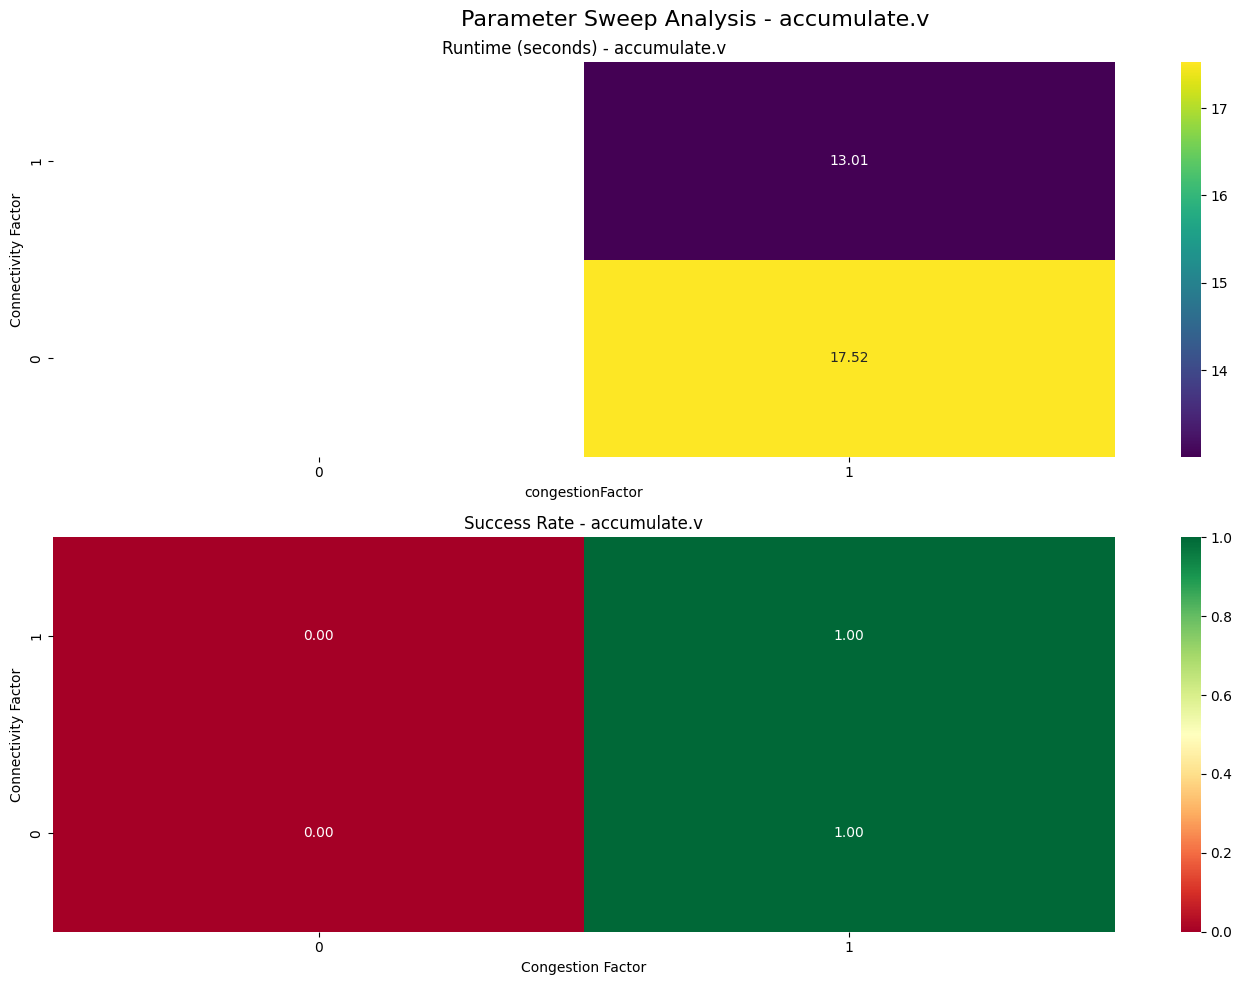

2025-06-18T12:55:37.218150+0100 | INFO | Heatmap saved for accumulate.v: /home/kelvin/FABulous_fork/myProject/PnR/parameter_sweep_results/parameter_sweep_heatmap_accumulate_20250618_125536.png


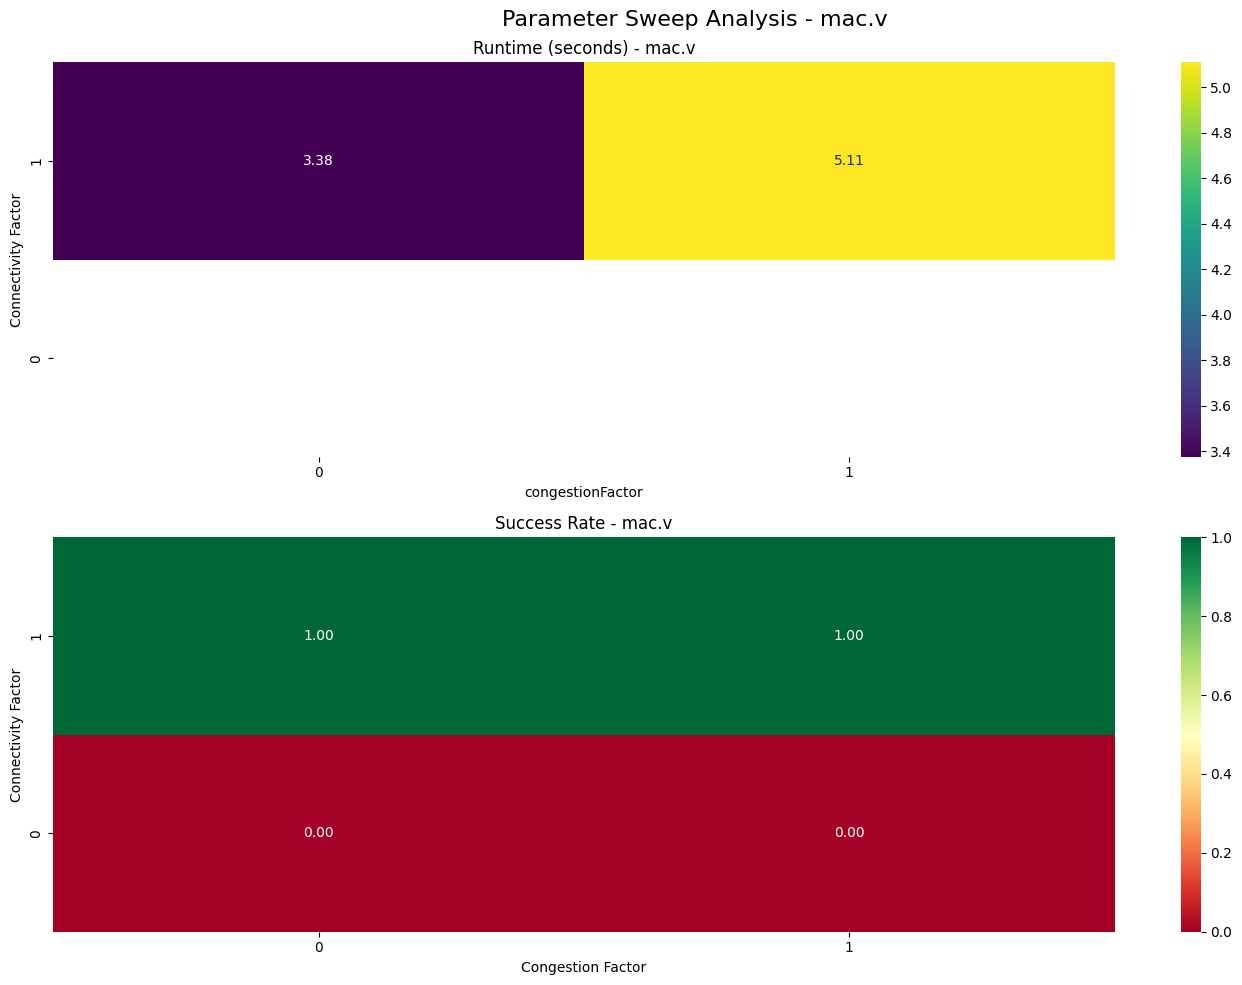

2025-06-18T12:55:37.694503+0100 | INFO | Heatmap saved for mac.v: /home/kelvin/FABulous_fork/myProject/PnR/parameter_sweep_results/parameter_sweep_heatmap_mac_20250618_125536.png


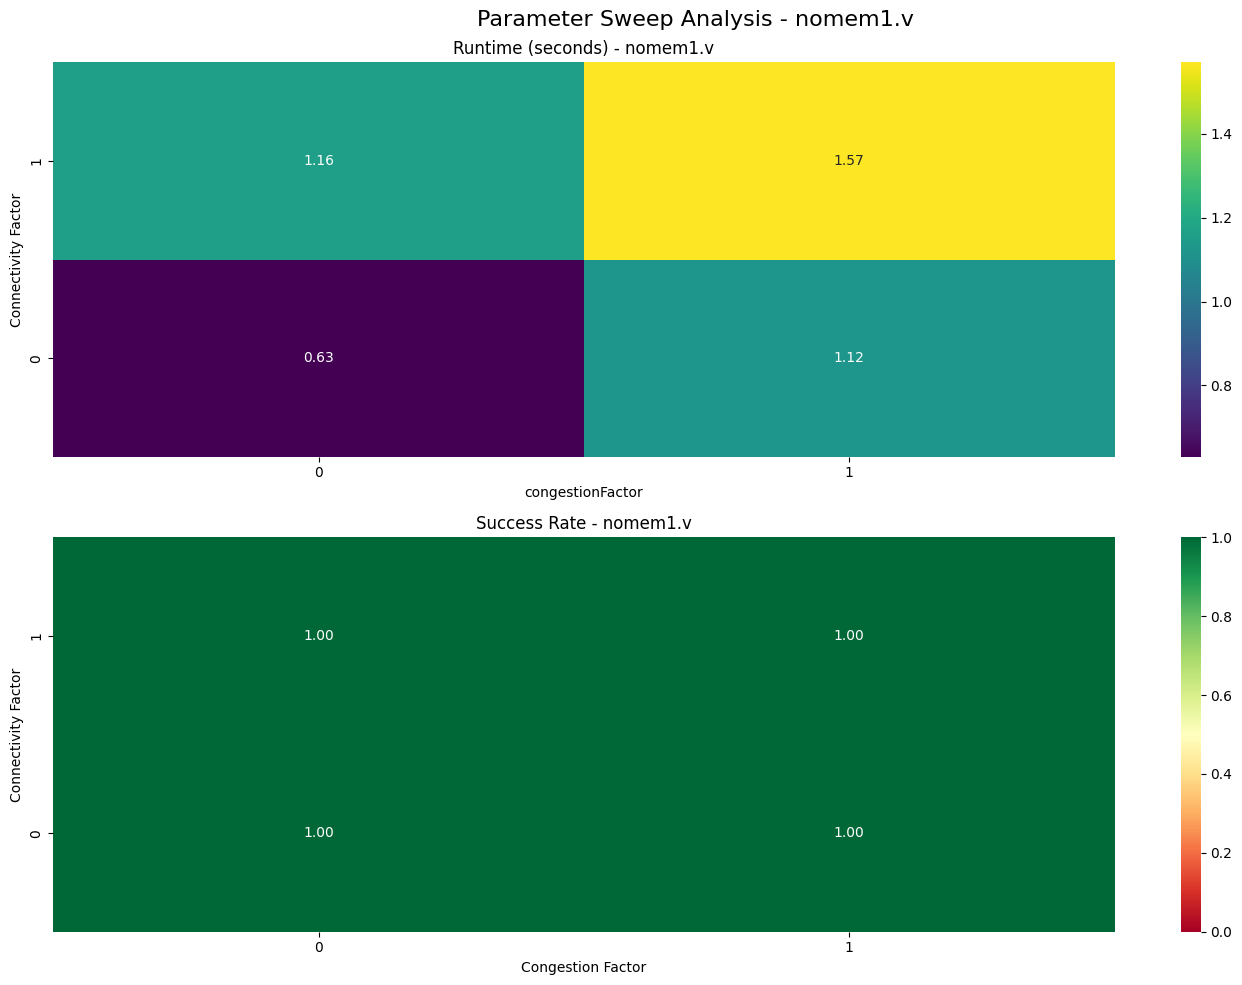

2025-06-18T12:55:38.162635+0100 | INFO | Heatmap saved for nomem1.v: /home/kelvin/FABulous_fork/myProject/PnR/parameter_sweep_results/parameter_sweep_heatmap_nomem1_20250618_125536.png


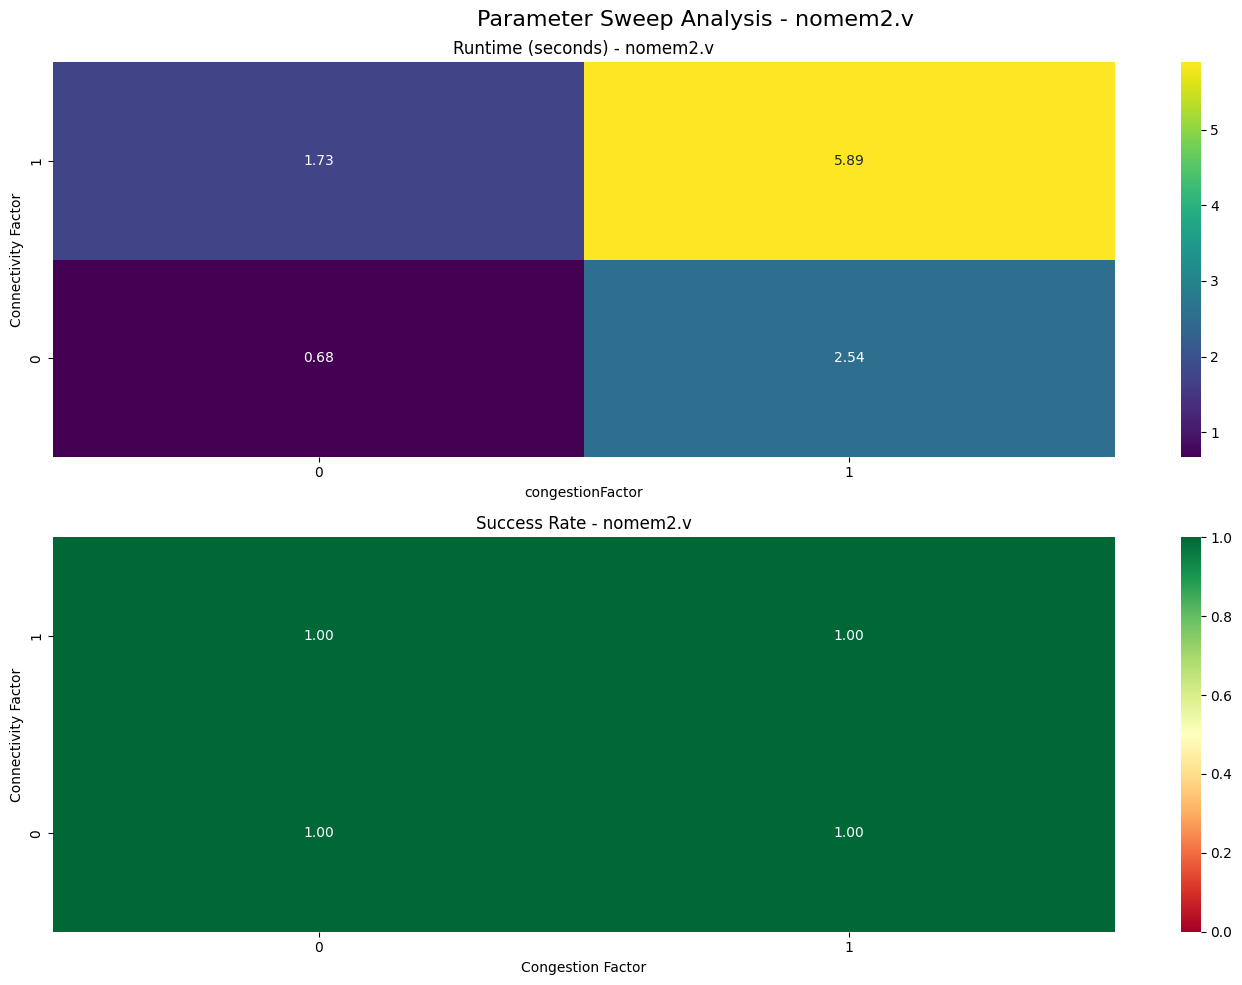

2025-06-18T12:55:38.730647+0100 | INFO | Heatmap saved for nomem2.v: /home/kelvin/FABulous_fork/myProject/PnR/parameter_sweep_results/parameter_sweep_heatmap_nomem2_20250618_125536.png
2025-06-18T12:55:38.731417+0100 | INFO | Creating combined visualization for all HDL sources...


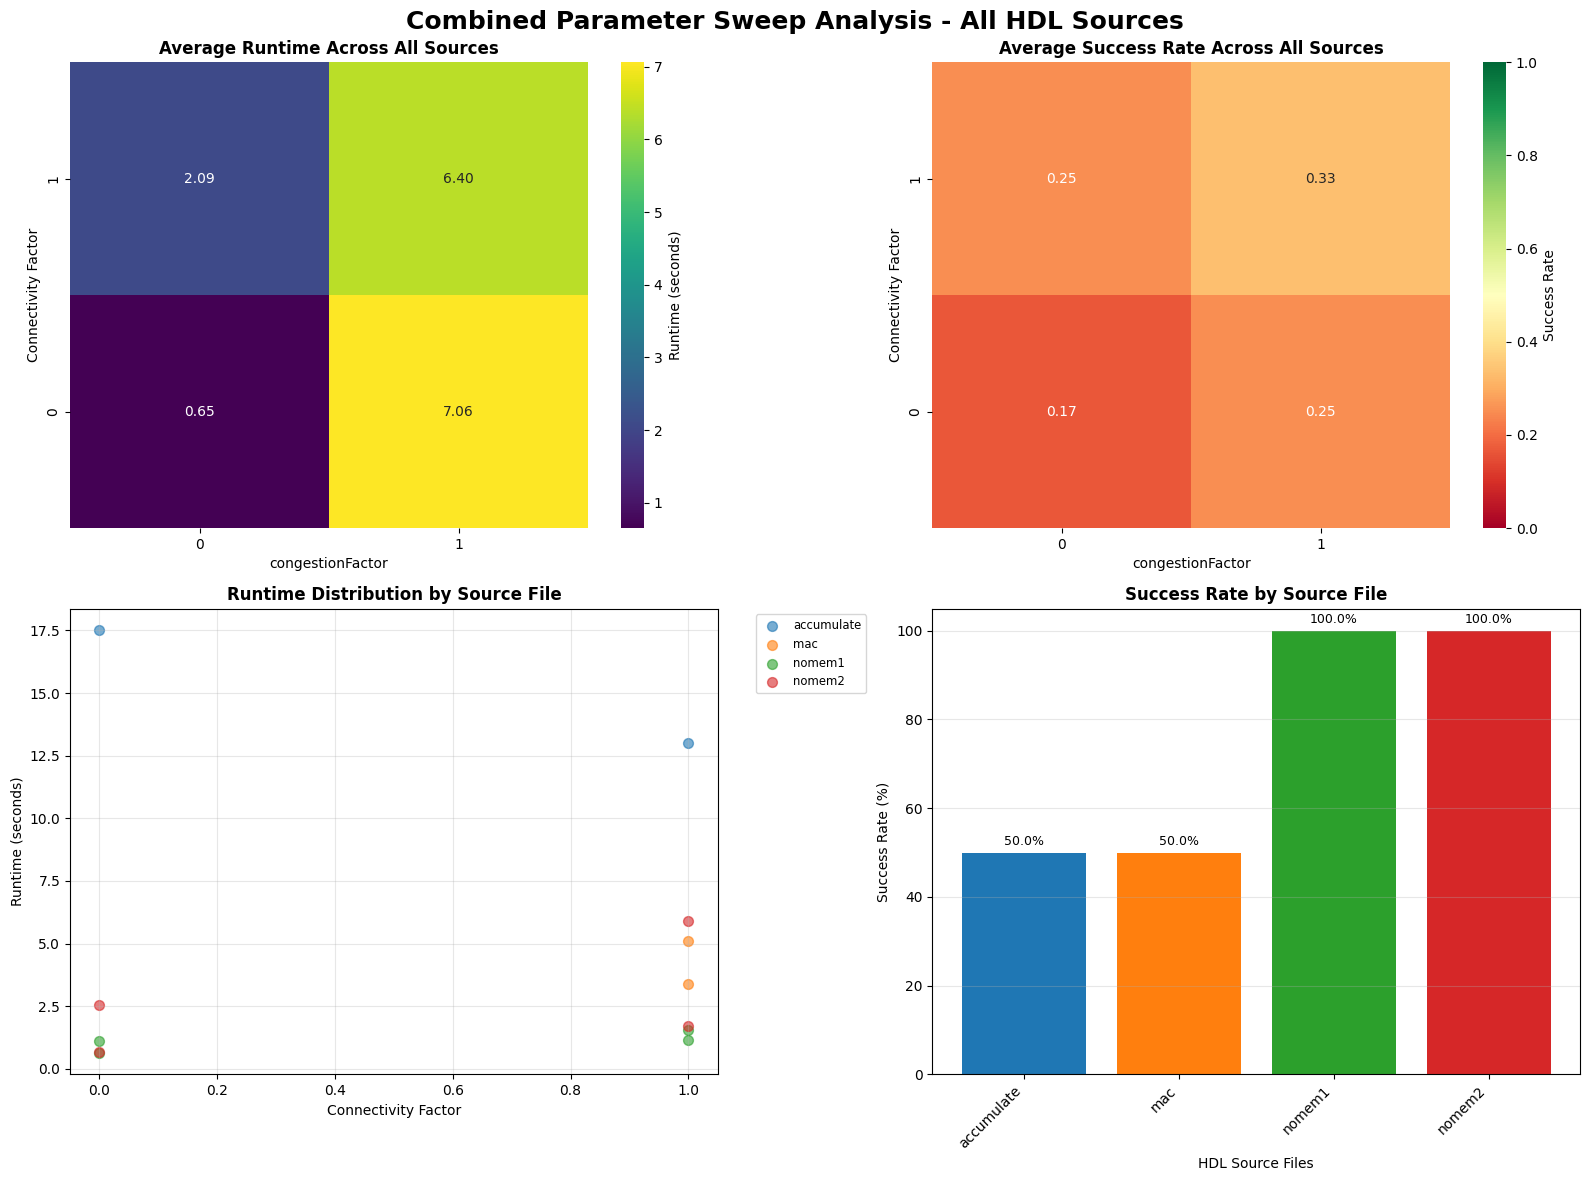

2025-06-18T12:55:39.684228+0100 | INFO | Combined analysis heatmap saved to: /home/kelvin/FABulous_fork/myProject/PnR/parameter_sweep_results/parameter_sweep_combined_analysis_20250618_125536.png
2025-06-18T12:55:39.686555+0100 | INFO | Creating enhanced failure detection visualizations...


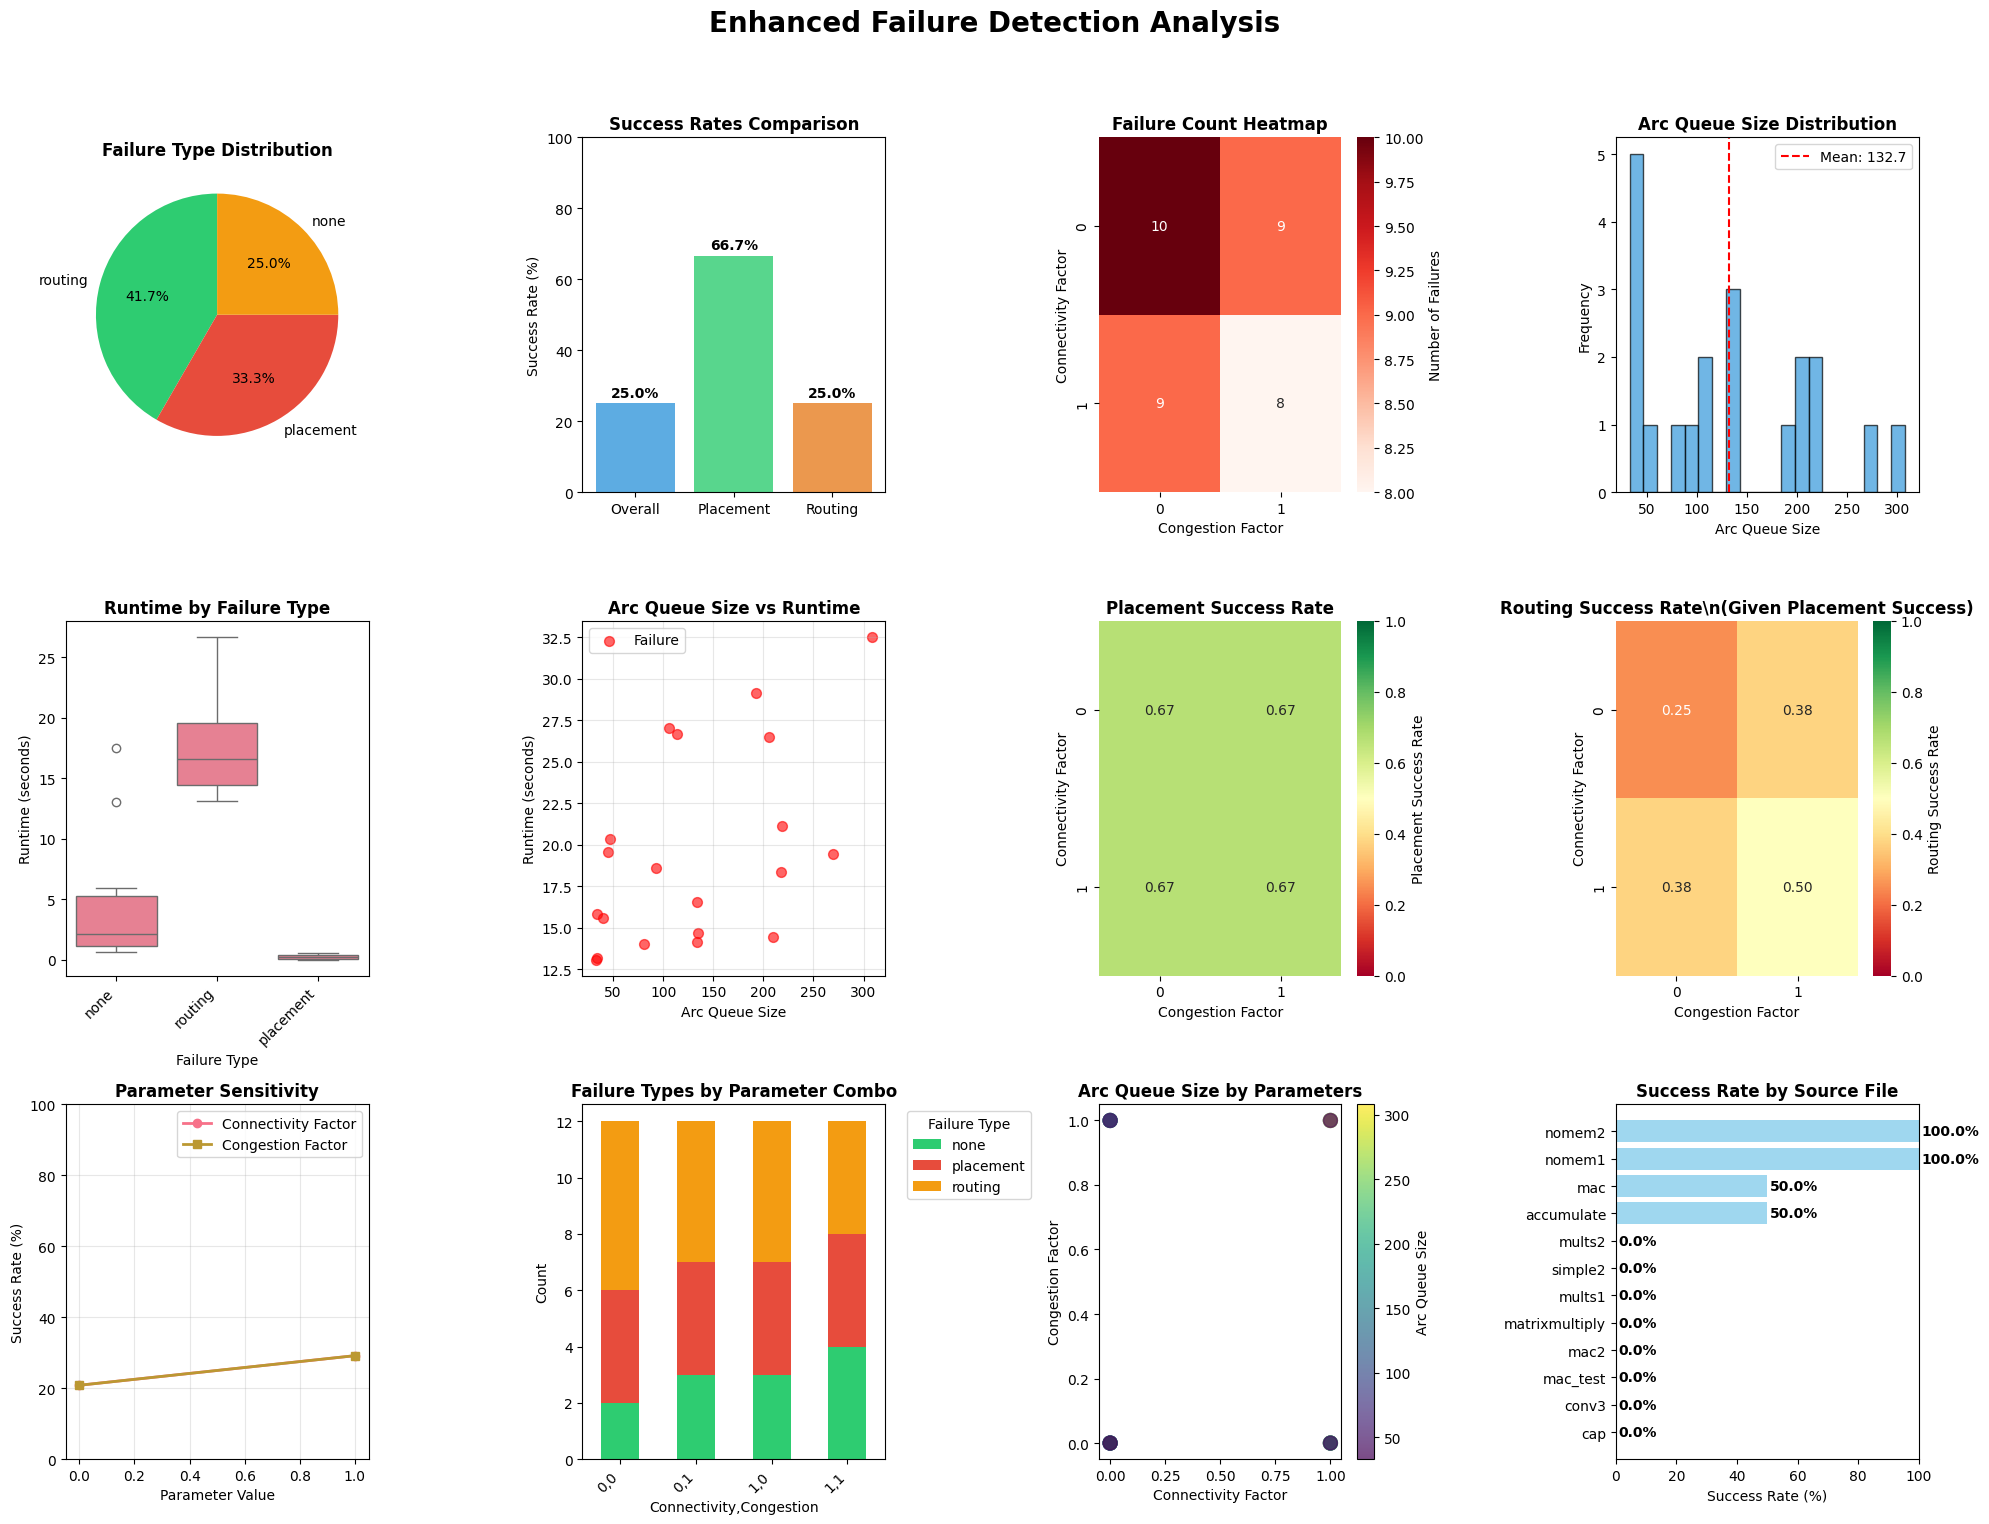

2025-06-18T12:55:41.842361+0100 | INFO | Enhanced failure analysis visualization saved to: /home/kelvin/FABulous_fork/myProject/PnR/parameter_sweep_results/enhanced_failure_analysis_20250618_125536.png
2025-06-18T12:55:41.843680+0100 | INFO | Creating additional specialized visualizations...


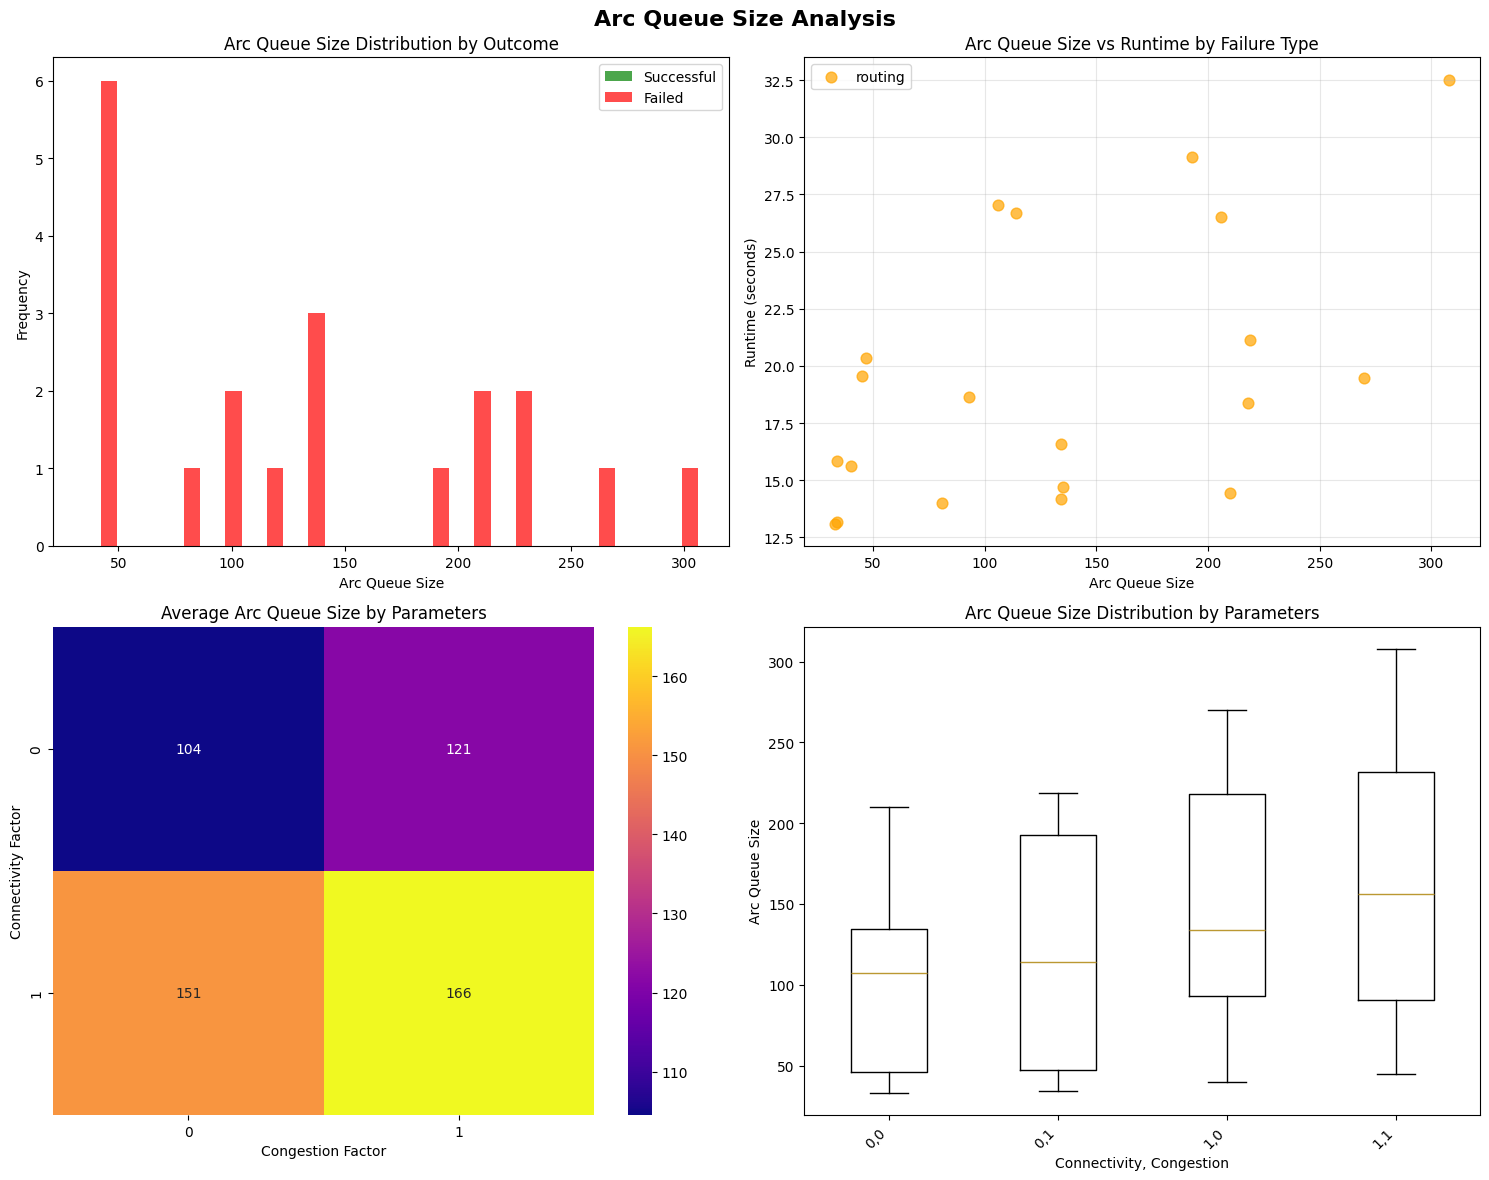

2025-06-18T12:55:42.885989+0100 | INFO | Arc queue analysis saved to: /home/kelvin/FABulous_fork/myProject/PnR/parameter_sweep_results/arc_queue_analysis_20250618_125536.png

PARAMETER SWEEP COMPLETE
Total parameter combinations tested: 48
Successful runs: 12
Source files processed: 12
Per-file success rates:
  accumulate.v: 50.0%
  cap.v: 0.0%
  conv3.v: 0.0%
  mac.v: 50.0%
  mac2.v: 0.0%
  mac_test.v: 0.0%
  matrixmultiply.v: 0.0%
  mults1.v: 0.0%
  mults2.v: 0.0%
  nomem1.v: 100.0%
  nomem2.v: 100.0%
  simple2.v: 0.0%
Results directory: /home/kelvin/FABulous_fork/myProject/PnR/parameter_sweep_results

=== Environment Variables ===
You can customize the following settings by setting environment variables:
- MY_FAB_ROOT: FABulous root directory (default: /home/kelvin/FABulous_fork)
- FAB_PROJ_DIR: Project directory name (default: myProject)
- GENERATED_VERILOG_DIR: Directory containing generated Verilog files
- OUTPUT_DIR: Results output directory
- BETA_VALUE: Placer heap beta value 

In [10]:
# Optional: Create visualizations if matplotlib is available
try:
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    if df['success'].any():
        successful_df = df[df['success']]

        # Round axis values to 2 decimal places to avoid floating point artifacts
        successful_df = successful_df.copy()
        successful_df["connectivityFactor"] = successful_df["connectivityFactor"].round(2)
        successful_df["congestionFactor"] = successful_df["congestionFactor"].round(2)
        df_rounded = df.copy()
        df_rounded["connectivityFactor"] = df_rounded["connectivityFactor"].round(2)
        df_rounded["congestionFactor"] = df_rounded["congestionFactor"].round(2)

        # Ensure both axes are sorted - congestion ascending (left to right), connectivity descending (bottom to top)
        connectivityOrder = sorted(successful_df["connectivityFactor"].unique(), reverse=True)  # Reverse to put 0.0 at bottom
        congestionOrder = sorted(successful_df["congestionFactor"].unique())  # Normal order to put 0.0 at left

        if hasMultipleFiles:
            # Create visualizations for each source file
            sourceFiles = sorted(successful_df['sourceFileName'].unique())
            
            for sourceFile in sourceFiles:
                sourceSuccessful = successful_df[successful_df['sourceFileName'] == sourceFile]
                sourceAll = df_rounded[df_rounded['sourceFileName'] == sourceFile]
                
                if len(sourceSuccessful) == 0:
                    continue
                    
                plt.figure(figsize=(14, 10))
                plt.suptitle(f"Parameter Sweep Analysis - {sourceFile}", fontsize=16)

                # Runtime heatmap
                plt.subplot(2, 1, 1)
                runtime_pivot = sourceSuccessful.pivot_table(
                    values="runtime", 
                    index="connectivityFactor", 
                    columns="congestionFactor", 
                    aggfunc="mean"
                ).reindex(index=connectivityOrder, columns=congestionOrder)
                sns.heatmap(runtime_pivot, annot=True, fmt=".2f", cmap="viridis")
                plt.title(f"Runtime (seconds) - {sourceFile}")
                plt.ylabel("Connectivity Factor")

                # Success rate heatmap - Fixed with proper colormap range
                plt.subplot(2, 1, 2)
                success_pivot = sourceAll.pivot_table(
                    values="success", 
                    index="connectivityFactor", 
                    columns="congestionFactor", 
                    aggfunc="mean"
                ).reindex(index=connectivityOrder, columns=congestionOrder)
                sns.heatmap(success_pivot, annot=True, fmt=".2f", cmap="RdYlGn", vmin=0, vmax=1)
                plt.title(f"Success Rate - {sourceFile}")
                plt.ylabel("Connectivity Factor")
                plt.xlabel("Congestion Factor")

                plt.tight_layout()

                # Save plot
                cleanFileName = Path(sourceFile).stem.replace(".", "_")
                plot_file = OUTPUT_DIR / f"parameter_sweep_heatmap_{cleanFileName}_{timestamp}.png"
                plt.savefig(plot_file, dpi=300, bbox_inches="tight")
                plt.show()

                logger.info(f"Heatmap saved for {sourceFile}: {plot_file}")
            
            # COMBINED VISUALIZATION FOR ALL HDL SOURCES
            logger.info("Creating combined visualization for all HDL sources...")
            
            # Combined heatmaps (average across all files)
            plt.figure(figsize=(16, 12))
            plt.suptitle("Combined Parameter Sweep Analysis - All HDL Sources", fontsize=18, fontweight='bold')

            # Combined Runtime heatmap (average across all successful runs)
            plt.subplot(2, 2, 1)
            combined_runtime_pivot = successful_df.pivot_table(
                values="runtime", 
                index="connectivityFactor", 
                columns="congestionFactor", 
                aggfunc="mean"
            ).reindex(index=connectivityOrder, columns=congestionOrder)
            sns.heatmap(combined_runtime_pivot, annot=True, fmt=".2f", cmap="viridis", cbar_kws={'label': 'Runtime (seconds)'})
            plt.title("Average Runtime Across All Sources", fontweight='bold')
            plt.ylabel("Connectivity Factor")

            # Combined Success rate heatmap - Fixed with proper colormap range
            plt.subplot(2, 2, 2)
            combined_success_pivot = df_rounded.pivot_table(
                values="success", 
                index="connectivityFactor", 
                columns="congestionFactor", 
                aggfunc="mean"
            ).reindex(index=connectivityOrder, columns=congestionOrder)
            sns.heatmap(combined_success_pivot, annot=True, fmt=".2f", cmap="RdYlGn", vmin=0, vmax=1, cbar_kws={'label': 'Success Rate'})
            plt.title("Average Success Rate Across All Sources", fontweight='bold')
            plt.ylabel("Connectivity Factor")

            # Runtime distribution by parameter values
            plt.subplot(2, 2, 3)
            # Create scatter plot colored by source file
            sourceFileColors = plt.cm.tab10(range(len(sourceFiles)))
            for i, sourceFile in enumerate(sourceFiles):
                sourceData = successful_df[successful_df['sourceFileName'] == sourceFile]
                if len(sourceData) > 0:
                    plt.scatter(sourceData['connectivityFactor'], sourceData['runtime'], 
                              alpha=0.6, label=Path(sourceFile).stem, s=50, color=sourceFileColors[i])
            plt.xlabel("Connectivity Factor")
            plt.ylabel("Runtime (seconds)")
            plt.title("Runtime Distribution by Source File", fontweight='bold')
            plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
            plt.grid(True, alpha=0.3)

            # Success count by source file
            plt.subplot(2, 2, 4)
            sourceSuccessCounts = []
            sourceNames = []
            for sourceFile in sourceFiles:
                sourceData = df_rounded[df_rounded['sourceFileName'] == sourceFile]
                successCount = sourceData['success'].sum()
                totalCount = len(sourceData)
                sourceSuccessCounts.append(successCount / totalCount * 100)
                sourceNames.append(Path(sourceFile).stem)
            
            bars = plt.bar(range(len(sourceNames)), sourceSuccessCounts, color=sourceFileColors[:len(sourceNames)])
            plt.xlabel("HDL Source Files")
            plt.ylabel("Success Rate (%)")
            plt.title("Success Rate by Source File", fontweight='bold')
            plt.xticks(range(len(sourceNames)), sourceNames, rotation=45, ha='right')
            plt.grid(True, alpha=0.3, axis='y')
            
            # Add value labels on bars
            for bar, value in zip(bars, sourceSuccessCounts):
                plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
                        f'{value:.1f}%', ha='center', va='bottom', fontsize=9)

            plt.tight_layout()

            # Save combined plot
            combined_plot_file = OUTPUT_DIR / f"parameter_sweep_combined_analysis_{timestamp}.png"
            plt.savefig(combined_plot_file, dpi=300, bbox_inches="tight")
            plt.show()

            logger.info(f"Combined analysis heatmap saved to: {combined_plot_file}")
            
        else:
            # Single file visualization (original behavior)
            plt.figure(figsize=(12, 8))

            # Runtime heatmap
            plt.subplot(2, 1, 1)
            runtime_pivot = successful_df.pivot_table(
                values="runtime", 
                index="connectivityFactor", 
                columns="congestionFactor", 
                aggfunc="mean"
            ).reindex(index=connectivityOrder, columns=congestionOrder)
            sns.heatmap(runtime_pivot, annot=True, fmt=".2f", cmap="viridis")
            plt.title("Runtime (seconds) - Connectivity Factor vs Congestion Factor")
            plt.ylabel("Connectivity Factor")

            # Success rate heatmap - Fixed with proper colormap range
            plt.subplot(2, 1, 2)
            success_pivot = df_rounded.pivot_table(
                values="success", 
                index="connectivityFactor", 
                columns="congestionFactor", 
                aggfunc="mean"
            ).reindex(index=connectivityOrder, columns=congestionOrder)
            sns.heatmap(success_pivot, annot=True, fmt=".2f", cmap="RdYlGn", vmin=0, vmax=1)
            plt.title("Success Rate - Connectivity Factor vs Congestion Factor")
            plt.ylabel("Connectivity Factor")
            plt.xlabel("Congestion Factor")

            plt.tight_layout()

            # Save plot
            plot_file = OUTPUT_DIR / f"parameter_sweep_heatmap_{timestamp}.png"
            plt.savefig(plot_file, dpi=300, bbox_inches="tight")
            plt.show()

            logger.info(f"Heatmap saved to: {plot_file}")

    else:
        logger.warning("No successful runs to visualize")
        
except ImportError:
    logger.info("matplotlib/seaborn not available. Skipping visualization.")
    print("To enable visualizations, install matplotlib and seaborn:")
    print("pip install matplotlib seaborn")

# Enhanced visualizations for failure detection analysis
try:
    import matplotlib.pyplot as plt
    import seaborn as sns
    import numpy as np
    
    # Only create enhanced visualizations if we have the new failure detection data
    if len(df) > 0 and 'failureType' in df.columns:
        logger.info("Creating enhanced failure detection visualizations...")
        
        # Set up the plot style
        plt.style.use('default')
        sns.set_palette("husl")
        
        # Create comprehensive failure analysis visualization
        fig = plt.figure(figsize=(20, 16))
        fig.suptitle('Enhanced Failure Detection Analysis', fontsize=20, fontweight='bold', y=0.98)
        
        # 1. Failure Type Distribution (Pie Chart)
        ax1 = plt.subplot(3, 4, 1)
        failureTypeCounts = df['failureType'].value_counts()
        colors = ['#2ecc71', '#e74c3c', '#f39c12', '#9b59b6', '#34495e', '#1abc9c']
        wedges, texts, autotexts = ax1.pie(failureTypeCounts.values, labels=failureTypeCounts.index, 
                                          autopct='%1.1f%%', startangle=90, colors=colors[:len(failureTypeCounts)])
        ax1.set_title('Failure Type Distribution', fontweight='bold', fontsize=12)
        
        # 2. Placement vs Routing Success Rates (Bar Chart)
        ax2 = plt.subplot(3, 4, 2)
        if 'placementSuccess' in df.columns and 'routingSuccess' in df.columns:
            successRates = {
                'Overall': df['success'].mean() * 100,
                'Placement': df['placementSuccess'].mean() * 100,
                'Routing': df['routingSuccess'].mean() * 100
            }
            bars = ax2.bar(successRates.keys(), successRates.values(), 
                          color=['#3498db', '#2ecc71', '#e67e22'], alpha=0.8)
            ax2.set_ylabel('Success Rate (%)')
            ax2.set_title('Success Rates Comparison', fontweight='bold', fontsize=12)
            ax2.set_ylim(0, 100)
            
            # Add value labels on bars
            for bar, value in zip(bars, successRates.values()):
                ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
                        f'{value:.1f}%', ha='center', va='bottom', fontweight='bold')
        
        # 3. Failure Type Heatmap by Parameters
        ax3 = plt.subplot(3, 4, 3)
        if len(df) > 1:
            # Create a pivot table for failure types
            failureTypeData = df.groupby(['connectivityFactor', 'congestionFactor'])['failureType'].apply(
                lambda x: x.value_counts().to_dict()
            ).reset_index()
            
            # Create heatmap showing most common failure type per parameter combination
            failureHeatmapData = df.pivot_table(
                values='success', 
                index='connectivityFactor', 
                columns='congestionFactor', 
                aggfunc=lambda x: (x == False).sum()  # Count failures
            )
            
            if not failureHeatmapData.empty:
                sns.heatmap(failureHeatmapData, annot=True, fmt='d', cmap='Reds', 
                           cbar_kws={'label': 'Number of Failures'}, ax=ax3)
                ax3.set_title('Failure Count Heatmap', fontweight='bold', fontsize=12)
                ax3.set_xlabel('Congestion Factor')
                ax3.set_ylabel('Connectivity Factor')
        
        # 4. Arc Queue Size Distribution
        ax4 = plt.subplot(3, 4, 4)
        if 'arcQueueSize' in df.columns:
            arcQueueSizes = df['arcQueueSize'].dropna()
            if len(arcQueueSizes) > 0:
                ax4.hist(arcQueueSizes, bins=20, alpha=0.7, color='#3498db', edgecolor='black')
                ax4.set_xlabel('Arc Queue Size')
                ax4.set_ylabel('Frequency')
                ax4.set_title('Arc Queue Size Distribution', fontweight='bold', fontsize=12)
                ax4.axvline(arcQueueSizes.mean(), color='r', linestyle='--', 
                           label=f'Mean: {arcQueueSizes.mean():.1f}')
                ax4.legend()
        
        # 5. Runtime vs Failure Type (Box Plot)
        ax5 = plt.subplot(3, 4, 5)
        if len(df) > 1:
            dfForBoxplot = df[df['runtime'] < df['runtime'].quantile(0.95)]  # Remove outliers
            sns.boxplot(data=dfForBoxplot, x='failureType', y='runtime', ax=ax5)
            ax5.set_title('Runtime by Failure Type', fontweight='bold', fontsize=12)
            ax5.set_xlabel('Failure Type')
            ax5.set_ylabel('Runtime (seconds)')
            plt.setp(ax5.get_xticklabels(), rotation=45, ha='right')
        
        # 6. Arc Queue Size vs Success (Scatter Plot)
        ax6 = plt.subplot(3, 4, 6)
        if 'arcQueueSize' in df.columns:
            arcQueueData = df.dropna(subset=['arcQueueSize'])
            if len(arcQueueData) > 0:
                successData = arcQueueData[arcQueueData['success'] == True]
                failureData = arcQueueData[arcQueueData['success'] == False]
                
                if len(successData) > 0:
                    ax6.scatter(successData['arcQueueSize'], successData['runtime'], 
                              c='green', alpha=0.6, label='Success', s=50)
                if len(failureData) > 0:
                    ax6.scatter(failureData['arcQueueSize'], failureData['runtime'], 
                              c='red', alpha=0.6, label='Failure', s=50)
                
                ax6.set_xlabel('Arc Queue Size')
                ax6.set_ylabel('Runtime (seconds)')
                ax6.set_title('Arc Queue Size vs Runtime', fontweight='bold', fontsize=12)
                ax6.legend()
                ax6.grid(True, alpha=0.3)
        
        # 7. Placement Success Heatmap - Fixed with proper colormap range
        ax7 = plt.subplot(3, 4, 7)
        if 'placementSuccess' in df.columns and len(df) > 1:
            placementSuccessHeatmap = df.pivot_table(
                values='placementSuccess', 
                index='connectivityFactor', 
                columns='congestionFactor', 
                aggfunc='mean'
            )
            
            if not placementSuccessHeatmap.empty:
                sns.heatmap(placementSuccessHeatmap, annot=True, fmt='.2f', cmap='RdYlGn', vmin=0, vmax=1,
                           cbar_kws={'label': 'Placement Success Rate'}, ax=ax7)
                ax7.set_title('Placement Success Rate', fontweight='bold', fontsize=12)
                ax7.set_xlabel('Congestion Factor')
                ax7.set_ylabel('Connectivity Factor')
        
        # 8. Routing Success Heatmap (given placement succeeded) - Fixed with proper colormap range
        ax8 = plt.subplot(3, 4, 8)
        if 'routingSuccess' in df.columns and 'placementSuccess' in df.columns:
            placementSuccessfulRuns = df[df['placementSuccess'] == True]
            if len(placementSuccessfulRuns) > 1:
                routingSuccessHeatmap = placementSuccessfulRuns.pivot_table(
                    values='routingSuccess', 
                    index='connectivityFactor', 
                    columns='congestionFactor', 
                    aggfunc='mean'
                )
                
                if not routingSuccessHeatmap.empty:
                    sns.heatmap(routingSuccessHeatmap, annot=True, fmt='.2f', cmap='RdYlGn', vmin=0, vmax=1,
                               cbar_kws={'label': 'Routing Success Rate'}, ax=ax8)
                    ax8.set_title('Routing Success Rate\\n(Given Placement Success)', 
                                 fontweight='bold', fontsize=12)
                    ax8.set_xlabel('Congestion Factor')
                    ax8.set_ylabel('Connectivity Factor')
        
        # 9. Parameter Sensitivity Analysis
        ax9 = plt.subplot(3, 4, 9)
        if len(df) > 1:
            # Calculate success rate for each parameter value
            connSuccessRates = df.groupby('connectivityFactor')['success'].mean()
            congSuccessRates = df.groupby('congestionFactor')['success'].mean()
            
            ax9.plot(connSuccessRates.index, connSuccessRates.values * 100, 
                    'o-', label='Connectivity Factor', linewidth=2, markersize=6)
            ax9.plot(congSuccessRates.index, congSuccessRates.values * 100, 
                    's-', label='Congestion Factor', linewidth=2, markersize=6)
            ax9.set_xlabel('Parameter Value')
            ax9.set_ylabel('Success Rate (%)')
            ax9.set_title('Parameter Sensitivity', fontweight='bold', fontsize=12)
            ax9.legend()
            ax9.grid(True, alpha=0.3)
            ax9.set_ylim(0, 100)
        
        # 10. Failure Type by Parameter Combination (Stacked Bar)
        ax10 = plt.subplot(3, 4, 10)
        if len(df) > 1:
            # Create parameter combination labels
            df['paramCombo'] = df['connectivityFactor'].astype(str) + ',' + df['congestionFactor'].astype(str)
            failureByCombo = df.groupby(['paramCombo', 'failureType']).size().unstack(fill_value=0)
            
            if not failureByCombo.empty:
                failureByCombo.plot(kind='bar', stacked=True, ax=ax10, 
                                   color=colors[:len(failureByCombo.columns)])
                ax10.set_title('Failure Types by Parameter Combo', fontweight='bold', fontsize=12)
                ax10.set_xlabel('Connectivity,Congestion')
                ax10.set_ylabel('Count')
                ax10.legend(title='Failure Type', bbox_to_anchor=(1.05, 1), loc='upper left')
                plt.setp(ax10.get_xticklabels(), rotation=45, ha='right')
        
        # 11. Arc Queue Size vs Parameters (3D-like effect using color)
        ax11 = plt.subplot(3, 4, 11)
        if 'arcQueueSize' in df.columns:
            arcQueueData = df.dropna(subset=['arcQueueSize'])
            if len(arcQueueData) > 0:
                scatter = ax11.scatter(arcQueueData['connectivityFactor'], 
                                     arcQueueData['congestionFactor'],
                                     c=arcQueueData['arcQueueSize'], 
                                     s=100, alpha=0.7, cmap='viridis')
                ax11.set_xlabel('Connectivity Factor')
                ax11.set_ylabel('Congestion Factor')
                ax11.set_title('Arc Queue Size by Parameters', fontweight='bold', fontsize=12)
                plt.colorbar(scatter, ax=ax11, label='Arc Queue Size')
        
        # 12. Success Rate Trend
        ax12 = plt.subplot(3, 4, 12)
        if hasMultipleFiles and len(df) > 1:
            # Success rate by source file
            sourceFileStats = df.groupby('sourceFileName')['success'].agg(['mean', 'count']).reset_index()
            sourceFileStats = sourceFileStats.sort_values('mean', ascending=True)
            
            bars = ax12.barh(range(len(sourceFileStats)), sourceFileStats['mean'] * 100, 
                           color='skyblue', alpha=0.8)
            ax12.set_yticks(range(len(sourceFileStats)))
            ax12.set_yticklabels([Path(f).stem for f in sourceFileStats['sourceFileName']], fontsize=10)
            ax12.set_xlabel('Success Rate (%)')
            ax12.set_title('Success Rate by Source File', fontweight='bold', fontsize=12)
            ax12.set_xlim(0, 100)
            
            # Add value labels
            for i, (bar, value) in enumerate(zip(bars, sourceFileStats['mean'] * 100)):
                ax12.text(value + 1, bar.get_y() + bar.get_height()/2, 
                         f'{value:.1f}%', va='center', fontweight='bold')
        else:
            # Simple success rate summary for single file
            overallSuccessRate = df['success'].mean() * 100
            ax12.bar(['Overall Success Rate'], [overallSuccessRate], color='lightgreen', alpha=0.8)
            ax12.set_ylabel('Success Rate (%)')
            ax12.set_title('Overall Success Rate', fontweight='bold', fontsize=12)
            ax12.set_ylim(0, 100)
            ax12.text(0, overallSuccessRate + 2, f'{overallSuccessRate:.1f}%', 
                     ha='center', va='bottom', fontweight='bold')
        
        # Adjust layout and save
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        
        # Save enhanced analysis plot
        enhanced_plot_file = OUTPUT_DIR / f"enhanced_failure_analysis_{timestamp}.png"
        plt.savefig(enhanced_plot_file, dpi=300, bbox_inches="tight")
        plt.show()
        
        logger.info(f"Enhanced failure analysis visualization saved to: {enhanced_plot_file}")
        
        # Create additional specialized visualizations if we have enough data
        if len(df) > 4:
            logger.info("Creating additional specialized visualizations...")
            
            # Arc Queue Size Analysis Plot
            if 'arcQueueSize' in df.columns:
                arcQueueData = df.dropna(subset=['arcQueueSize'])
                if len(arcQueueData) > 0:
                    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
                    fig.suptitle('Arc Queue Size Analysis', fontsize=16, fontweight='bold')
                    
                    # Arc queue size by success/failure
                    successfulArcs = arcQueueData[arcQueueData['success'] == True]['arcQueueSize']
                    failedArcs = arcQueueData[arcQueueData['success'] == False]['arcQueueSize']
                    
                    ax1.hist([successfulArcs, failedArcs], bins=15, alpha=0.7, 
                            label=['Successful', 'Failed'], color=['green', 'red'])
                    ax1.set_xlabel('Arc Queue Size')
                    ax1.set_ylabel('Frequency')
                    ax1.set_title('Arc Queue Size Distribution by Outcome')
                    ax1.legend()
                    
                    # Arc queue size vs runtime with failure type coloring
                    failureTypeColors = {'none': 'green', 'placement': 'red', 'routing': 'orange', 
                                       'timeout': 'purple', 'exception': 'brown', 'unknown': 'gray'}
                    
                    for failureType in arcQueueData['failureType'].unique():
                        typeData = arcQueueData[arcQueueData['failureType'] == failureType]
                        ax2.scatter(typeData['arcQueueSize'], typeData['runtime'], 
                                  alpha=0.7, label=failureType, 
                                  color=failureTypeColors.get(failureType, 'gray'), s=60)
                    
                    ax2.set_xlabel('Arc Queue Size')
                    ax2.set_ylabel('Runtime (seconds)')
                    ax2.set_title('Arc Queue Size vs Runtime by Failure Type')
                    ax2.legend()
                    ax2.grid(True, alpha=0.3)
                    
                    # Arc queue size heatmap
                    if len(arcQueueData) > 1:
                        arcQueueHeatmap = arcQueueData.pivot_table(
                            values='arcQueueSize', 
                            index='connectivityFactor', 
                            columns='congestionFactor', 
                            aggfunc='mean'
                        )
                        
                        if not arcQueueHeatmap.empty:
                            sns.heatmap(arcQueueHeatmap, annot=True, fmt='.0f', cmap='plasma', ax=ax3)
                            ax3.set_title('Average Arc Queue Size by Parameters')
                            ax3.set_xlabel('Congestion Factor')
                            ax3.set_ylabel('Connectivity Factor')
                    
                    # Arc queue size box plot by parameter values
                    if len(arcQueueData) > 4:
                        combinedData = []
                        labels = []
                        for conn in sorted(arcQueueData['connectivityFactor'].unique()):
                            for cong in sorted(arcQueueData['congestionFactor'].unique()):
                                paramData = arcQueueData[
                                    (arcQueueData['connectivityFactor'] == conn) & 
                                    (arcQueueData['congestionFactor'] == cong)
                                ]['arcQueueSize']
                                if len(paramData) > 0:
                                    combinedData.append(paramData.values)
                                    labels.append(f'{conn},{cong}')
                        
                        if combinedData:
                            ax4.boxplot(combinedData, tick_labels=labels)
                            ax4.set_xlabel('Connectivity, Congestion')
                            ax4.set_ylabel('Arc Queue Size')
                            ax4.set_title('Arc Queue Size Distribution by Parameters')
                            plt.setp(ax4.get_xticklabels(), rotation=45, ha='right')
                    
                    plt.tight_layout()
                    
                    # Save arc queue analysis
                    arc_plot_file = OUTPUT_DIR / f"arc_queue_analysis_{timestamp}.png"
                    plt.savefig(arc_plot_file, dpi=300, bbox_inches="tight")
                    plt.show()
                    
                    logger.info(f"Arc queue analysis saved to: {arc_plot_file}")
    
    else:
        logger.info("Enhanced failure detection data not available - skipping enhanced visualizations")
        
except ImportError:
    logger.info("matplotlib/seaborn not available for enhanced visualizations.")
    
except Exception as e:
    logger.error(f"Error creating enhanced visualizations: {e}")
    print(f"Error in enhanced visualization: {e}")

# Final summary
print("\n" + "="*50)
print("PARAMETER SWEEP COMPLETE")
print("="*50)
print(f"Total parameter combinations tested: {len(df)}")
print(f"Successful runs: {df['success'].sum()}")
if hasMultipleFiles:
    print(f"Source files processed: {df['sourceFileName'].nunique()}")
    print("Per-file success rates:")
    for sourceFile in sorted(df['sourceFileName'].unique()):
        sourceResults = df[df['sourceFileName'] == sourceFile]
        successRate = sourceResults['success'].mean() * 100
        print(f"  {sourceFile}: {successRate:.1f}%")
print(f"Results directory: {OUTPUT_DIR}")
print("="*50)

# Environment variables that can be set:
print("\n=== Environment Variables ===")
print("You can customize the following settings by setting environment variables:")
print("- MY_FAB_ROOT: FABulous root directory (default: /home/kelvin/FABulous_fork)")
print("- FAB_PROJ_DIR: Project directory name (default: myProject)")
print("- GENERATED_VERILOG_DIR: Directory containing generated Verilog files")
print("- OUTPUT_DIR: Results output directory")
print("- BETA_VALUE: Placer heap beta value (default: 0.9)")
print("- PLACE_TRIALS: Number of place trials (default: 1)")
print("- ROUTER_TIMEOUT: Router timeout in seconds (default: 20000)")
print("="*50)

## 6. Enhanced Failure Detection Visualizations

The notebook now includes comprehensive visualizations for the enhanced failure detection data:

### 🎯 **Main Analysis Dashboard (12-panel visualization)**
1. **Failure Type Distribution** - Pie chart showing breakdown of failure types
2. **Success Rates Comparison** - Bar chart comparing overall, placement, and routing success rates  
3. **Failure Count Heatmap** - Shows which parameter combinations fail most often
4. **Arc Queue Size Distribution** - Histogram of arc queue sizes across all runs
5. **Runtime by Failure Type** - Box plot showing runtime patterns for different failure types
6. **Arc Queue vs Runtime** - Scatter plot colored by success/failure status
7. **Placement Success Heatmap** - Parameter combinations vs placement success rate
8. **Routing Success Heatmap** - Routing success rate given placement succeeded
9. **Parameter Sensitivity** - Line plot showing how each parameter affects success rate
10. **Failure Types by Parameter Combo** - Stacked bar chart of failure types per parameter combination
11. **Arc Queue Size by Parameters** - Scatter plot with color-coded arc queue sizes
12. **Success Rate by Source File** - Comparison across different HDL source files

### 🔬 **Specialized Arc Queue Analysis (4-panel visualization)**
- **Arc Queue Distribution by Outcome** - Histogram comparing successful vs failed runs
- **Arc Queue vs Runtime by Failure Type** - Detailed scatter plot with failure type coloring
- **Arc Queue Size Heatmap** - Average arc queue size by parameter combinations
- **Arc Queue Box Plots** - Distribution analysis by parameter combinations

### 📊 **Key Insights from Visualizations**
- **Identify parameter sweet spots** for placement and routing success
- **Understand routing complexity** through arc queue size analysis  
- **Optimize parameter tuning** based on failure type patterns
- **Compare HDL source complexity** across different benchmark files
- **Detect correlation patterns** between parameters, runtime, and failure modes

All visualizations are automatically saved as high-resolution PNG files in the results directory.